In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.utils import normalize

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import MAPE, MAE
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

#---Import moduls from stock-prediction package
from stock_prediction.data_prep import Data_Prep
from stock_prediction.features_exo import exo_selection

#---API related
import os 
from math import sqrt 
import yfinance as yf
from datetime import date, timedelta, datetime
from stock_prediction.data_prep_api import Data_Prep_Api
from stock_prediction.features_exo_api import exo_selection_api

# Test 1: LSTM
learning rate, momentum

## Data exploration

In [4]:
def load_preproc_data(company='vinci'):
    """This function allows to load the data for chosen company,
    to select features make changes directly inside this function."""
    #---(1) Instantiate the Class 
    prep_class = Data_Prep(company, 252)



    #---(2) Load the first dataframe ready to use if no more modification
    df = prep_class.data_prep()



    #---(3) Function that allows us to delete some of the features we don't want to use for modelling 
    # Log Return is to False by default
    # *******************
    # if period < 252 , don't use Annual_vol
    #********************
    prep_class.select_features(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                            Volume_Change=False, Period_Volum=True, Annual_Vol=True,
                            Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    #---(4) Function that add the exogenous features that you need to select 
    # returns the dataframe ready to modelling 
    # and the list of the columns to rebase it later - no VIX because no rebase for VIX - kept unchanged 
    df = exo_selection(df, sp500=True, gold=True, eurusd=True, nasdaq=True, crude=True, vix=True)

    #---(5) Sort values to make sure they are ordered *in case and drop data column
    df = df.sort_values('Date')
#     df = df.drop(columns='Date')
    
    df = df.set_index('Date')
    
    #---Company code on stock market
    idx = df.columns[0][7:]
    
    return df, idx

In [5]:
data, idx = load_preproc_data('vinci')

In [6]:
data

,Return_DG.PA,High-Low_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Period_Volum_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif,Return_S&P500,Return_Gold,Return_Usd,Return_Nasdaq,Return_Crude,Vix_No_Rebase
Date,,,,,,,,,,,,,,,
2017-05-31,0.015547,0.022332,0.007076,0.015150,0.331698,0.202937,-0.001862,0.000000,0.017409,-0.007514,0.007844,0.003832,-0.000753,-0.026983,0.1041
2017-06-01,-0.002187,0.012279,0.009799,0.002456,-0.209472,0.202602,0.003497,0.000000,-0.005684,-0.003694,-0.003931,0.006431,0.007794,0.000828,0.0989
2017-06-02,0.006833,0.009021,0.002689,0.006314,-0.332583,0.202592,0.006953,-0.186563,-0.000119,0.001219,0.007735,-0.002468,0.009440,-0.014475,0.0975
2017-06-05,-0.003713,0.009155,0.005913,0.003224,-0.577419,0.201847,0.000000,0.000000,-0.003713,0.002787,0.001958,0.005799,-0.001605,-0.005455,0.1007
2017-06-06,-0.013239,0.009780,0.008727,0.001043,-0.171234,0.201653,-0.010479,-0.215993,-0.002760,-0.001566,0.011803,-0.002128,-0.003275,0.016667,0.1045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,-0.005139,0.016498,0.014529,0.001941,-0.453011,0.333450,-0.007640,-0.538190,0.002501,0.000000,0.000000,-0.000256,0.000000,0.000000,0.1676
2021-06-01,0.011192,0.010714,0.004044,0.006642,-0.329363,0.333514,0.007994,-0.340290,0.003199,-0.001445,0.000210,0.003511,-0.000892,0.021110,0.1790
2021-06-02,-0.000958,0.011579,0.005113,0.006433,-0.451458,0.332512,0.004114,-0.369720,-0.005072,0.003642,0.002417,-0.001234,0.001445,0.016391,0.1748


In [178]:
idx

'DG.PA'

In [7]:
data.shape

(1027, 15)

In [11]:
data_60 = data[:int(data.shape[0]*0.6)]

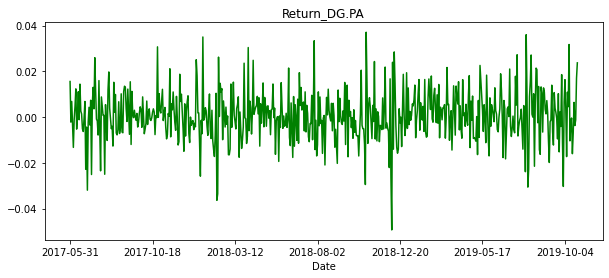

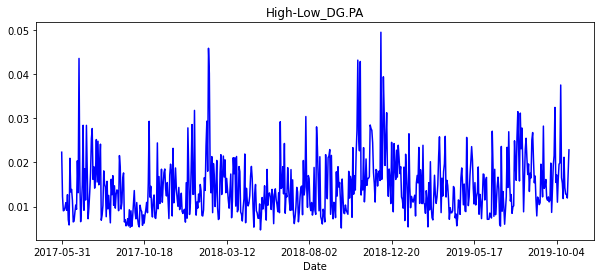

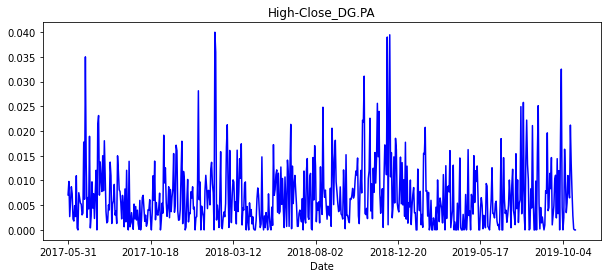

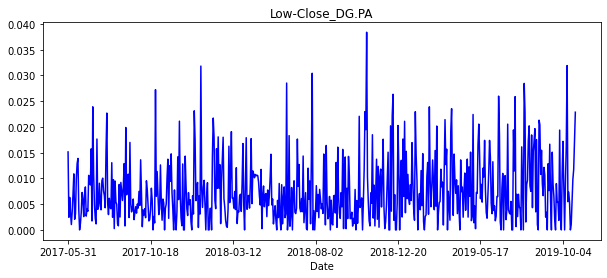

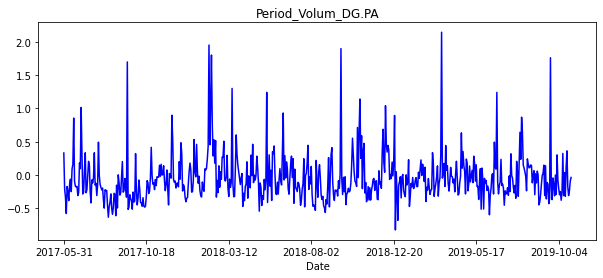

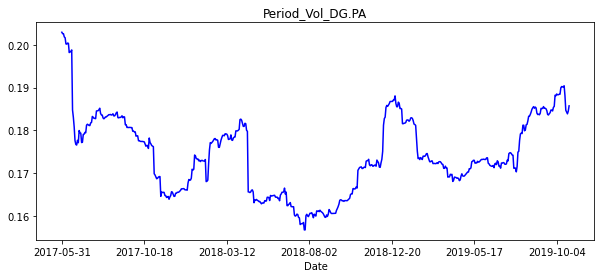

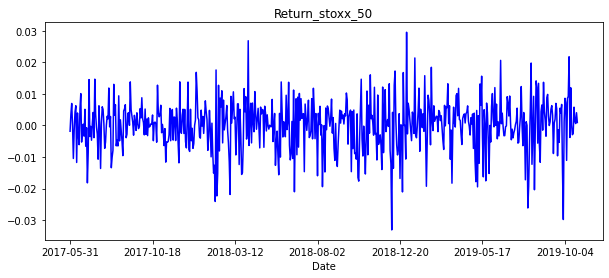

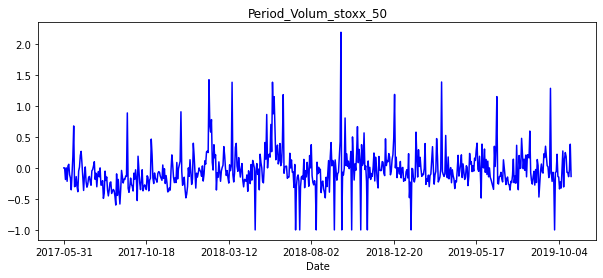

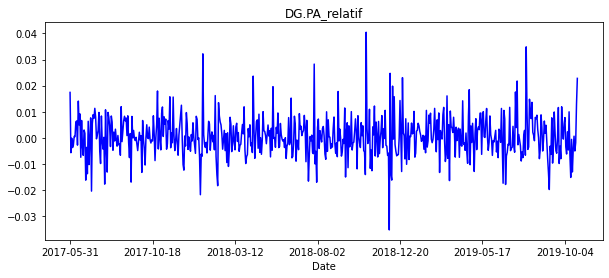

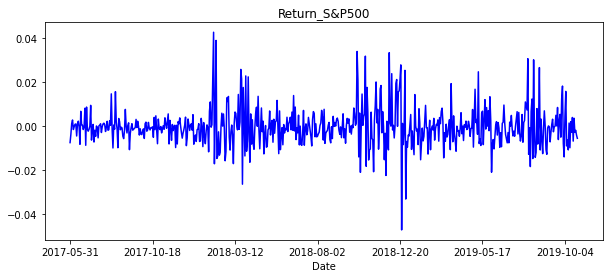

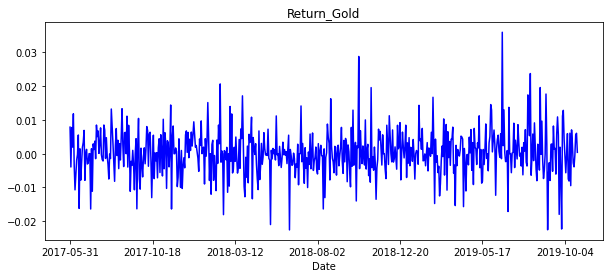

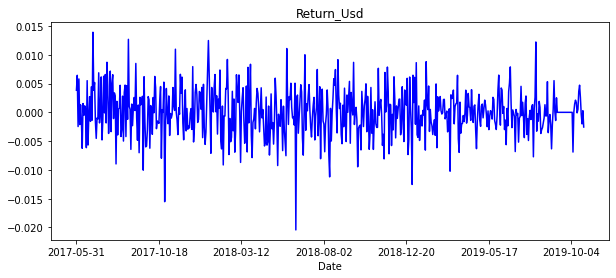

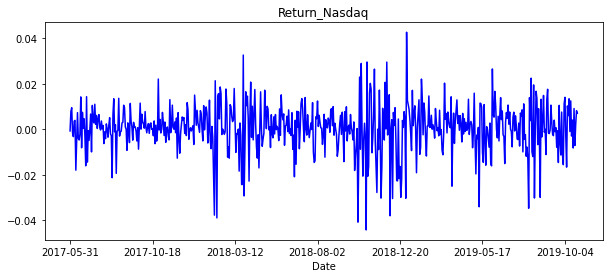

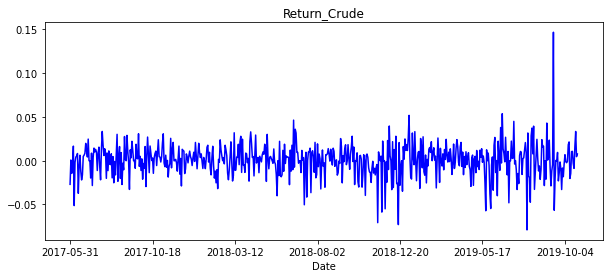

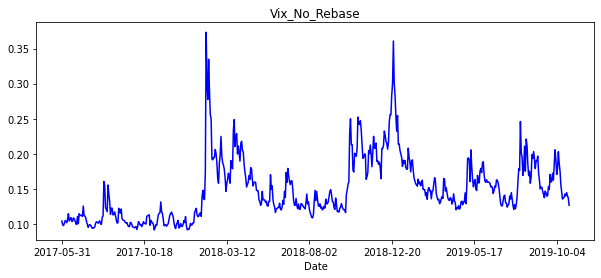

In [12]:
#---Plot the temporal progression of different features of our Data

%matplotlib inline

for col in data_60.columns:
    color="green" if col == f"Return_{idx}" else "blue"
    data_60[col].plot(figsize=(10,4), color=color)
    plt.title(col)

    plt.show()

## Data preprocessing TS oriented

In [7]:
data.head()

,Return_DG.PA,High-Low_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Volume-Change_DG.PA,Period_Volum_DG.PA,Annual_Vol_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif,Return_S&P500,Return_Gold,Return_Usd,Return_Nasdaq,Return_Crude,Vix_No_Rebase
0,0.015547,0.022332,0.007076,0.015150,0.963615,0.331698,0.202937,0.202937,-0.001862,0.000000,0.017409,-0.007514,0.007844,0.003832,-0.000753,-0.026983,0.1041
1,-0.002187,0.012279,0.009799,0.002456,-0.407210,-0.209472,0.202602,0.202602,0.003497,0.000000,-0.005684,-0.003694,-0.003931,0.006431,0.007794,0.000828,0.0989
2,0.006833,0.009021,0.002689,0.006314,-0.156808,-0.332583,0.202592,0.202592,0.006953,-0.186563,-0.000119,0.001219,0.007735,-0.002468,0.009440,-0.014475,0.0975
3,-0.003713,0.009155,0.005913,0.003224,-0.368494,-0.577419,0.201847,0.201847,0.000000,0.000000,-0.003713,0.002787,0.001958,0.005799,-0.001605,-0.005455,0.1007
4,-0.013239,0.009780,0.008727,0.001043,0.957079,-0.171234,0.201653,0.201653,-0.010479,-0.215993,-0.002760,-0.001566,0.011803,-0.002128,-0.003275,0.016667,0.1045


**K-fold Vinci**

<AxesSubplot:>

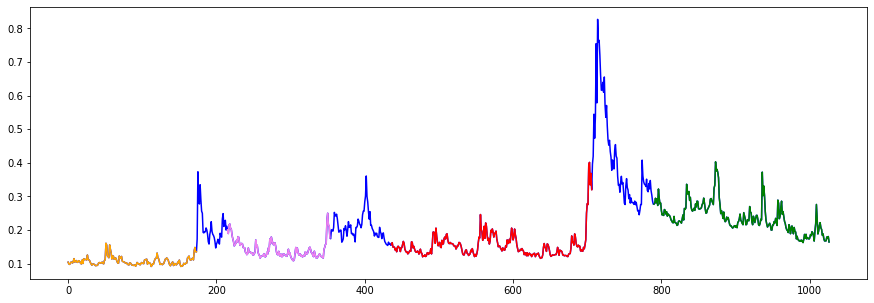

In [8]:
#---Create slices based on 'Vix_no_rebase' (relativité) to train our model on.
data_kfold, idx = load_preproc_data('vinci')

#---Fold_1
data_kfold_1_stop = int(0.17*data.shape[0])
data_kfold_1 = data[:data_kfold_1_stop].copy()

#---Fold_2
data_kfold_2_start = int(0.21*data.shape[0])
data_kfold_2_stop = int(0.345*data.shape[0])
data_kfold_2 = data[data_kfold_2_start:data_kfold_2_stop].copy()

#---Fold_3
data_kfold_3_start = int(0.425*data.shape[0])
data_kfold_3_stop = int(0.6885*data.shape[0])
data_kfold_3 = data[data_kfold_3_start:data_kfold_3_stop].copy()

#---Fold_4
data_kfold_4_start = int(0.77*data.shape[0])
data_kfold_4 = data[data_kfold_4_start:].copy()


#---Plot sample
%matplotlib inline
data_kfold['Vix_No_Rebase'].plot(figsize=(15,5), color='blue')
data_kfold_1['Vix_No_Rebase'].plot(figsize=(15,5), color='orange')
data_kfold_2['Vix_No_Rebase'].plot(figsize=(15,5), color='violet')
data_kfold_3['Vix_No_Rebase'].plot(figsize=(15,5), color='red')
data_kfold_4['Vix_No_Rebase'].plot(figsize=(15,5), color='green')

**K-fold Airbus**

<AxesSubplot:>

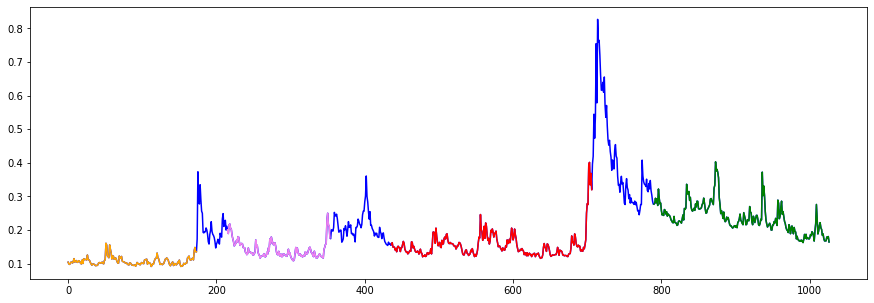

In [85]:
#---Create slices based on 'Vix_no_rebase' (relativité) to train our model on.
data_kfold, idx = load_preproc_data('bnp')

#---Fold_1
data_kfold_1_stop = int(0.17*data.shape[0])
data_kfold_1 = data[:data_kfold_1_stop].copy()

#---Fold_2
data_kfold_2_start = int(0.21*data.shape[0])
data_kfold_2_stop = int(0.345*data.shape[0])
data_kfold_2 = data[data_kfold_2_start:data_kfold_2_stop].copy()

#---Fold_3
data_kfold_3_start = int(0.425*data.shape[0])
data_kfold_3_stop = int(0.6885*data.shape[0])
data_kfold_3 = data[data_kfold_3_start:data_kfold_3_stop].copy()

#---Fold_4
data_kfold_4_start = int(0.77*data.shape[0])
data_kfold_4 = data[data_kfold_4_start:].copy()


#---Plot sample
%matplotlib inline
data_kfold['Vix_No_Rebase'].plot(figsize=(15,5), color='blue')
data_kfold_1['Vix_No_Rebase'].plot(figsize=(15,5), color='orange')
data_kfold_2['Vix_No_Rebase'].plot(figsize=(15,5), color='violet')
data_kfold_3['Vix_No_Rebase'].plot(figsize=(15,5), color='red')
data_kfold_4['Vix_No_Rebase'].plot(figsize=(15,5), color='green')

In [8]:
def k_fold_split(fold, horizon=1, threshold=0.8):
    
    # gap = 0 here
    gap = horizon - 1

    # set a train: 80%, val: 20% sizes
    train_size = int(threshold*df.shape[0])

    fold_train = df[:train]
    fold_val = df[train+gap:val]
    
    return fold_train, fold_val

In [4]:
# To avoid data leakage we have to split sets chronologically.

def train_test_val_split(df, horizon=1, train_threshold=0.6, val_threshold=0.8):
    
    # here gap=0, if we take a longer horizon it'll matter
    gap = horizon - 1

    # set a train: 60%, test: 20%, val: 20% sizes
    train = int( train_threshold*df.shape[0])
    val = int(val_threshold*df.shape[0])


    df_train = df[:train]
    df_val = df[train:val]
    df_test = df[val+gap:] # gap can matter later
    
    return df_train, df_val, df_test

In [5]:
def subsample_sequence(df, idx, length=10, horizon=1): #, target = 'DG.PA'
    
    """This function is able to get a subsequence X and a corresponding target y
    N days after the last observationexpressed in horizon variable."""
    
    last_possible = df.shape[0] - length - horizon
    #random seed  = 0
    # np.random.seed(0) 
    random_start = np.random.randint(0, last_possible) 
    
    X = df[random_start: random_start+length].values # drop(columns=[f'Return_{target}']).
    
    # target: Close price to predict
    y = df.iloc[random_start+length+horizon][f'Return_{idx}'] # [f'Return_{target}']; taregt = 'Return'

    return X, y

In [6]:
def shift_sequences(df, idx, length=10, horizon=1):
    
    """This function is able to get as many subsequences for X and a corresponding target y
    Nas possible, taking in account lenght of sequence and horizon."""
    
    last_possible = df.shape[0] - length - horizon
    X=[]
    y=[]
    for start in range(last_possible):
        X.append(df[start: start+length].values)
        y.append(df.iloc[start+length+horizon][f'Return_{idx}'])
    
    # random permutation of the sequences
#     np.random.seed(42)
    perm = np.random.permutation(last_possible)
    X = np.array(X)[perm, :, :]
    y = np.array(y)[perm]
    return X, y

In [7]:
def get_X_y(df, idx, length=10, horizon=1, number_of_sequences=100):
    
    """This function returns a given number of X and y sequences of given length."""
    
    X, y = [], []

    for _ in range(int(number_of_sequences)):
        
        xi, yi = subsample_sequence(df, idx, length, horizon)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

## Model RNN

In [8]:
company_dict = {
    'asml' : 'ASML.AS',
    'lvmh': 'MC.PA',
    'sap' : 'SAP.DE',
    'linde' : 'LIN',
    'siemens' : 'SIE.DE',
    'total' : 'FP.PA',
    'sanofi' : 'SAN.PA',
    'allianz' : 'ALV.DE', 
    'schneider' : 'SU.PA',
    'iberdrola' : 'IBE.MC',
    'enel' : 'ENEL.MI',
    'air-liquide' : 'AI.PA',
    'basf' : 'BAS.DE',
    'bayer' : 'BAYN.DE',
    'adidas' : 'ADS.DE',
    'airbus' : 'AIR.PA',
    'adyen' : 'ADYEN.AS',
    'deutsche-telecom' : 'DTE.DE',
    'daimler' : 'DAI.DE',
    'bnp' : 'BNP.PA',
    'anheuser-busch' : 'ABI.BR',
    'vinci' : 'DG.PA',
    # 'prosus' : 'PRX.AS',
    'banco-santander' : 'SAN.MC',
    'philips' : 'PHIA.AS',
    'kering' : 'KER.PA',
    'deutsche-post' : 'DPW.DE',
    'axa' : 'CS.PA',
    'safran' : 'SAF.PA',
    'danone'  : 'BN.PA',
    'essilor' : 'EL.PA',
    'intensa' : 'ISP.MI',
    'munchener' : 'MUV2.DE',
    'pernod' : 'RI.PA',
    'vonovia' : 'VNA.DE',
    'vw' : 'VOW3.DE',
    'ing' : 'INGA.AS',
    'crh' : 'CRG.IR',
    'industria-diseno' : 'ITX.MC',
    'kone' : 'KNEBV.HE',
    'deutsche-borse' : 'DB1.DE',
    'ahold' : 'AHOG.DE',
    'flutter' : 'FLTR.IR',
    'amadeus' : 'AMS.MC',
    'engie' : 'ENGI.PA',
    'bmw' : 'BMW.DE',
    'vivendi' : 'VIV.PA',
    'eni' : 'ENI.MI',
    'nokia' : 'NOKIA.HE'
}

In [9]:
#---Pipeline
def train_model(df,
                idx,
                train_threshold=0.6,
                val_threshold=0.8,
                nb_sequences=50,
                len_=20,
                l_rate=0.01,
                momentum=0.9,
                loss='MAE',
                metric=MAE,
                patience=50,
                batch_size=32,
                horizon=1,
                plot_history=False,
                verbose=2):
    """Train model function:
    Allows to split sequences and gets X and y for train, val, test sets;
    Initializes a model with (Normalization), LSTM/GRU/Conv1D and 2 fully connected layers.
    Returns: X_train, y_train, X_test, y_test, model"""
    
#     regul = 0

    if not isinstance(df, list):
        df = [df]

    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    y_test = []
    for nb_df, df_loc in enumerate(df):
        idx_loc = idx[nb_df]
        
        #---Split train, test, val sets
        df_train, df_val, df_test = train_test_val_split(
            df_loc, train_threshold=train_threshold, val_threshold=val_threshold)

        #---Get train, test, val X and y sequences
    #     X_train_loc, y_train_loc = get_X_y(df_train, idx_loc, length=len_, number_of_sequences=nb_sequences)
    #     X_val_loc, y_val_loc = get_X_y(df_val, idx_loc, length=len_, number_of_sequences=nb_sequences) #round(nb_sequences*0.2)
    #     X_test_loc, y_test_loc = get_X_y(df_test, idx_loc, length=len_, number_of_sequences=nb_sequences) #round(nb_sequences*0.2)

        X_train_loc, y_train_loc = shift_sequences(df_train, idx_loc, length=len_)
        X_val_loc, y_val_loc = shift_sequences(df_val, idx_loc, length=len_)
        X_test_loc, y_test_loc = shift_sequences(df_test, idx_loc, length=len_)
        
        X_train.append(X_train_loc)
        y_train.append(y_train_loc)
        
        X_val.append(X_val_loc)
        y_val.append(y_val_loc)
        
        X_test.append(X_test_loc)
        y_test.append(y_test_loc)
    
    # Data concatenation
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_val = np.concatenate(X_val)
    y_val = np.concatenate(y_val)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)
    
    # Data shuffle (random, different for train / val / test)
    perm = np.random.permutation(len(X_train))
    X_train, y_train = X_train[perm], y_train[perm]
    perm = np.random.permutation(len(X_val))
    X_val, y_val = X_val[perm], y_val[perm]
    perm = np.random.permutation(len(X_test))
    X_test, y_test = X_test[perm], y_test[perm]
    
#     print(np.any(np.isnan(X_train)))
#     print(np.any(np.isnan(X_val)))
#     print(np.any(np.isnan(X_test)))

    normalizer = Normalization()
    normalizer.adapt(X_train)  # , axis=-1, order=1 as minmax

    #---Initialize the model
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(len_, X_train.shape[-1])))
    model.add(normalizer)
    #     model.add(layers.BatchNormalization(input_shape=(len_,17)))
    
#     model.add(layers.GRU(50, return_sequences=True, activation='tanh'))
#     model.add(layers.GRU(30, return_sequences=True, activation='tanh'))
#     model.add(layers.GRU(20, return_sequences=False, activation='tanh'))

    model.add(layers.Conv1D(128, 2, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPool1D(pool_size=2))
    
    model.add(layers.Conv1D(64, 2, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPool1D(pool_size=2))
    
    model.add(layers.Conv1D(32, 2, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPool1D(pool_size=2))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='linear'))
    
#     model.add(layers.LSTM(50, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(regul)))
#     model.add(layers.LSTM(30, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(regul)))
#     model.add(layers.LSTM(20, return_sequences=False, activation='tanh', kernel_regularizer=regularizers.l2(regul)))

#     model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(regul)))
#     model.add(layers.Dense(1, activation='linear', kernel_regularizer=regularizers.l2(regul)))

    model.compile(
        loss=loss,
        optimizer=Adam(l_rate),  # RMSprop(learning_rate=l_rate, momentum=momentum), 
        metrics=[metric])
    
    print(X_train.shape)
    print(model.summary())

    es = EarlyStopping(monitor='val_loss',
                       patience=patience,
                       restore_best_weights=True)
    
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                           patience=round(patience/2))

    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,
                        batch_size=batch_size,
                        callbacks=[es, lr],
                        verbose=verbose)

    if plot_history:

        plot_loss(history, patience)


#     res = model.evaluate(X_test, y_test, verbose=0)
#     return res[1]
    return X_train, y_train, X_val, y_val, X_test, y_test, model

In [10]:
#---Plot train val losses function

def plot_loss(history, patience):
    plt.semilogy(history.history['loss']) # plot train loss
    plt.semilogy(history.history['val_loss']) # plot val loss
    plt.title('Loss & Metric')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
#     plt.plot(history.history['mean_absolute_percentage_error'])
#     plt.plot(history.history['val_mean_absolute_percentage_error'])
#     plt.title('MAPE')
#     plt.ylabel('Mean Absolute Percentage Error')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='best')
#     plt.show()
    
    stop_epoch = max(history.epoch)-patience
    val_mae = history.history['val_mean_absolute_error'][stop_epoch]

    print(f"early stopping at {max(history.epoch)} epoch.\nval_mae: {val_mae}")

## Load the data for "Vinci" and make some tests

In [194]:
# Find companies with invalid features (nan or inf)
ianvalid_companies = [idx[ind] for ind in np.where([np.count_nonzero(x.isin([np.nan, np.inf, -np.inf]).any(1)) for x in data])[0]]

In [195]:
#---load the data with selected features
data = []
idx = []
for company in company_dict.keys():
    # Only load data if company is valid
    if company_dict[company] not in invalid_companies:
        data_loc, idx_loc = load_preproc_data(company)
        data.append(data_loc[:int(data_loc.shape[0]*0.6)])  # Pre-covid data
        idx.append(idx_loc)
    else:
        print(f'Company {company} contains invalid entries, ignoring it.')

(16399, 20, 16)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 20, 16)            33        
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 19, 128)           4224      
_________________________________________________________________
dropout_36 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 8, 64)             16448     
_________________________________________________________________
dropout_37 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 4,

Epoch 49/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 50/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 51/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104


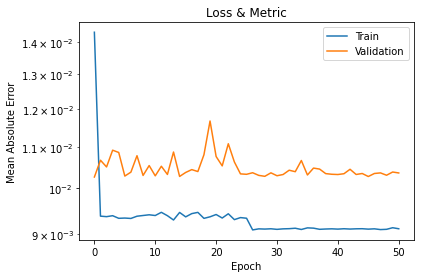

early stopping at 50 epoch.
val_mae: 0.01026382390409708


In [196]:
#---train the model
X_train, y_train, X_val, y_val, X_test, y_test, model = train_model(df=data,
                                                                    idx=idx,
                                                                    len_=20, 
                                                                    l_rate=0.01,
                                                                    batch_size=32,
                                                                    patience=50,
                                                                    loss='MAE',
                                                                    metric=MAE,
                                                                    plot_history=True, 
                                                                    verbose=2)

**! Need to recode the model to be able to check step by step the gradient descent**

In [197]:
X_test.shape

(4829, 20, 16)

In [198]:
#---Prediction
res = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)

In [199]:
y_pred.shape

(4829, 1)

Prediction of stock return on J+1: [[0.00118564]
 [0.00118564]
 [0.00118564]
 ...
 [0.00118564]
 [0.00118564]
 [0.001202  ]] with mae 0.010109594091773033


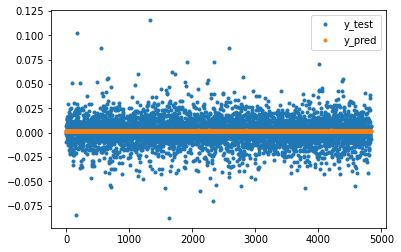

In [200]:
plt.plot(y_test, '.',  label='y_test')
plt.plot(y_pred, '.', label='y_pred') #'.'
plt.legend()

print(f"Prediction of stock return on J+1: {y_pred} with mae {res[1]}")

In [201]:
#baseline
np.mean(np.abs(y_test))

0.010177065090330745

## Same test with API data

### Load the data

In [92]:
# instantiate the Class 
prep_class = Data_Prep_Api('vinci', 252)

# load the first dataframe ready to use if no more modification
data_api = prep_class.data_prep_api()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [93]:
data_api.head()

,Date,Return_DG.PA,Log_Return_DG.PA,High-Low_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Volume-Change_DG.PA,Period_Volum_DG.PA,Annual_Vol_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif
0,2017-06-13,0.001160,0.001159,0.005810,0.002703,0.003099,-0.200583,-0.248449,0.198194,0.198194,0.004512,0.000000,-0.003351
1,2017-06-14,0.011070,0.011009,0.020957,0.010948,0.009900,0.452843,0.093502,0.198444,0.198444,-0.000996,0.000000,0.012065
2,2017-06-15,-0.001146,-0.001147,0.013297,0.000382,0.012910,0.061252,0.161533,0.198371,0.198371,-0.002240,0.000000,0.001094
3,2017-06-16,0.014402,0.014300,0.013885,0.000000,0.013885,0.596913,0.856392,0.198809,0.198809,0.000284,0.000000,0.014119
4,2017-06-19,0.002638,0.002635,0.011448,0.007519,0.003900,-0.517420,-0.091332,0.184772,0.184772,0.008347,-0.098257,-0.005709


In [94]:
data_api.shape

(1023, 13)

In [95]:
# function that allows us to delete some of the features we don't want to use for modelling 
# Log Return is to False by default

# *******************
# if period < 252 , don't use Annual_vol
#********************
prep_class.select_features_api(data_api, Return = True, Log_Return=False, High_Low=False, High_Close=True, Low_Close=True,
                        Volume_Change=False, Period_Volum=True, Annual_Vol=True,
                        Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

,Date,Return_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Period_Volum_DG.PA,Annual_Vol_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif
0,2017-06-13,0.001160,0.002703,0.003099,-0.248449,0.198194,0.198194,0.004512,0.000000,-0.003351
1,2017-06-14,0.011070,0.010948,0.009900,0.093502,0.198444,0.198444,-0.000996,0.000000,0.012065
2,2017-06-15,-0.001146,0.000382,0.012910,0.161533,0.198371,0.198371,-0.002240,0.000000,0.001094
3,2017-06-16,0.014402,0.000000,0.013885,0.856392,0.198809,0.198809,0.000284,0.000000,0.014119
4,2017-06-19,0.002638,0.007519,0.003900,-0.091332,0.184772,0.184772,0.008347,-0.098257,-0.005709
...,...,...,...,...,...,...,...,...,...,...
1018,2021-06-07,0.004922,0.003940,0.009568,-0.306718,0.329186,0.329186,-0.000797,-0.169992,0.005719
1019,2021-06-08,0.002769,0.002442,0.005338,-0.454690,0.329146,0.329146,0.000175,-0.143250,0.002594
1020,2021-06-09,0.015610,0.002928,0.019942,-0.138483,0.328310,0.328310,-0.001824,-0.150341,0.017434
1021,2021-06-10,-0.016102,0.017747,0.000744,-0.380286,0.328743,0.328743,0.004652,-0.235479,-0.020754


In [97]:
# function that add the exogenous features that you need to select 
# returns the dataframe ready to modelling 
# and the list of the columns to rebase it later - no VIX because no rebase for VIX - kept unchanged 
data_api = exo_selection_api(data_api, ["sp500","gold", "eurusd", "nasdaq", "crude", "vix"])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [98]:
data_api.head()

,Date,Return_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Period_Volum_DG.PA,Annual_Vol_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif,Return_sp500,Return_gold,Return_eurusd,Return_nasdaq,Return_crude,Vix_No_Rebase
0,2017-06-13,0.001160,0.002703,0.003099,-0.248449,0.198194,0.198194,0.004512,0.000000,-0.003351,0.004512,-0.000237,-0.000515,0.007272,0.008246,0.1042
1,2017-06-14,0.011070,0.010948,0.009900,0.093502,0.198444,0.198444,-0.000996,0.000000,0.012065,-0.000996,0.005530,0.001132,-0.004096,-0.037236,0.1064
2,2017-06-15,-0.001146,0.000382,0.012910,0.161533,0.198371,0.198371,-0.002240,0.000000,0.001094,-0.002240,-0.016185,0.000617,-0.004744,-0.006036,0.1090
3,2017-06-16,0.014402,0.000000,0.013885,0.856392,0.198809,0.198809,0.000284,0.000000,0.014119,0.000284,0.001438,-0.006142,-0.002229,0.006298,0.1038
4,2017-06-19,0.002638,0.007519,0.003900,-0.091332,0.184772,0.184772,0.008347,-0.098257,-0.005709,0.008347,-0.007815,0.005503,0.014183,-0.012070,0.1037


**Load API data to predict return for a given period**

In [11]:
#greater than the start date and smaller than the end date
def load_predict_data(company=None, start_date = '2020-01-03', end_date = '2020-12-31', len_=20):
    
    prep_class = Data_Prep_Api(company, 252)
    df = prep_class.data_prep_api() # (max=True)
    prep_class.select_features_api(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                        Volume_Change=False, Period_Volum=True, Annual_Vol=True,
                        Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    df = exo_selection_api(df, ["sp500","gold", "eurusd", "nasdaq", "crude", "vix"]) # ,max=True)

    df = df.sort_values('Date')
    
    start_date_delta = str((datetime.strptime('2020-01-03', '%Y-%m-%d') - timedelta(days=len_)).date())
    mask = (df['Date'] >= start_date_delta) & (df['Date'] < end_date)
    df = df.loc[mask]
    
    df = df.set_index('Date')
    
    #Company code on stock market
    idx = df.columns[0][7:]
    
    return df, idx

In [220]:
data__test, idx__test = load_predict_data('vinci')
data__test.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Return_DG.PA,High-Low_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Period_Volum_DG.PA,Annual_Vol_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif,Return_sp500,Return_gold,Return_eurusd,Return_nasdaq,Return_crude,Vix_No_Rebase
Date,,,,,,,,,,,,,,,,
2019-12-16,0.009770,0.006682,0.002217,0.004454,-0.215089,0.168908,0.168908,0.007148,0.128345,0.002622,0.007148,-0.000407,-0.005507,0.009084,0.002331,0.1214
2019-12-17,-0.003427,0.008713,0.006877,0.001824,-0.029703,0.168932,0.168932,0.000335,0.069601,-0.003762,0.000335,-0.000271,0.001125,0.001036,0.012124,0.1229
2019-12-18,-0.013147,0.014962,0.014962,0.000000,0.338315,0.169557,0.169557,-0.000432,0.119372,-0.012715,-0.000432,-0.001356,0.001294,0.000496,-0.000164,0.1258
2019-12-19,-0.002050,0.013872,0.005751,0.008075,0.263648,0.168985,0.168985,0.004459,0.039108,-0.006509,0.004459,0.003803,-0.003179,0.006738,0.004760,0.1250
2019-12-20,0.020538,0.020119,0.000000,0.020119,1.536334,0.170058,0.170058,0.004945,0.800921,0.015593,0.004945,-0.002368,0.000901,0.004247,-0.012741,0.1251


In [222]:
#---load the data with selected features

prediction = {}

 # data_data_to_predict_loc.shape[0]
for company in ['vinci']: #company_dict.keys():
    data_to_predict_loc, idx__loc = load_predict_data(company)
    X_test_loc, y_test_loc = shift_sequences(df = data_to_predict_loc, idx = idx__loc, length=20)

    prediction_loc = model.predict(X_test_loc)
    prediction[company] = prediction_loc

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


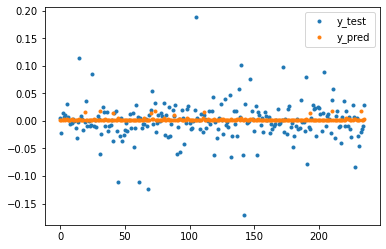

In [229]:
plt.plot(y_test_loc, '.', label='y_test')
plt.plot(prediction['vinci'], '.', label = 'y_pred')
plt.legend()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


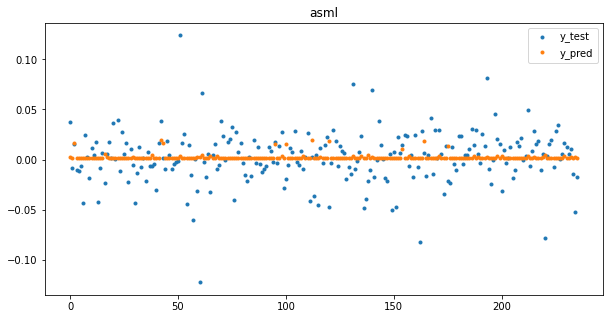

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


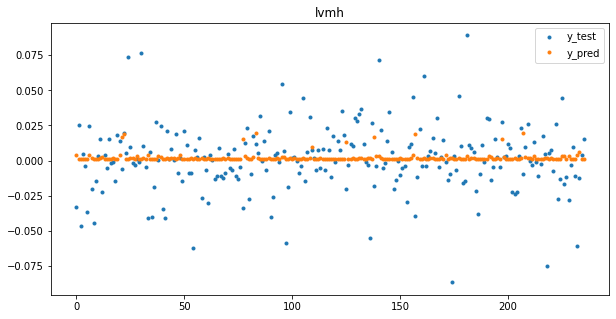

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


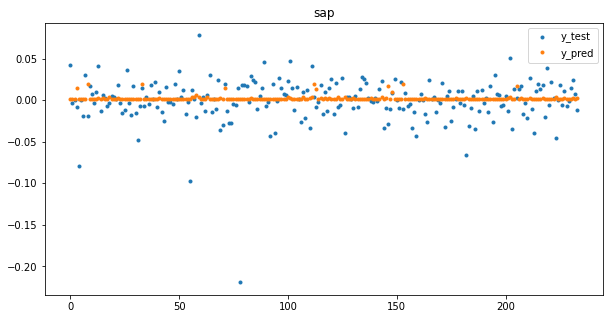

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(239, 20, 16)


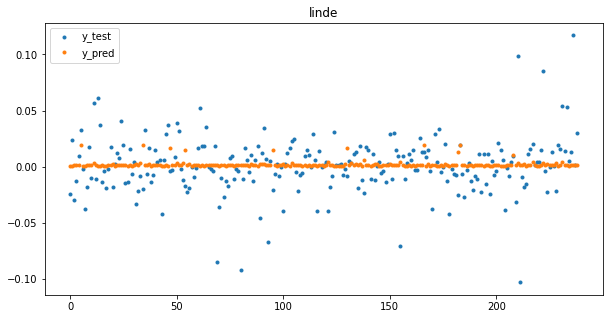

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


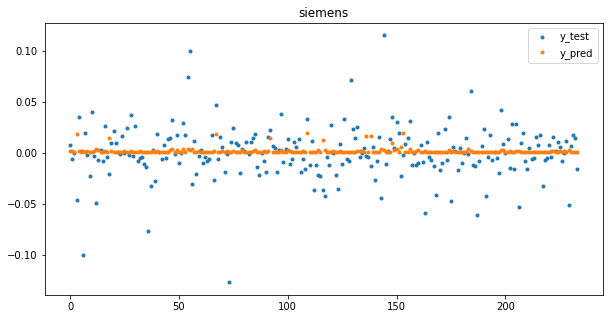

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


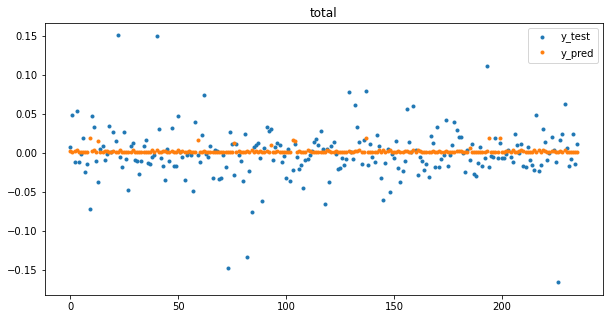

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


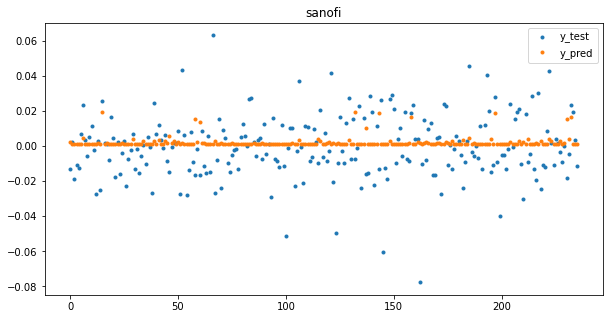

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


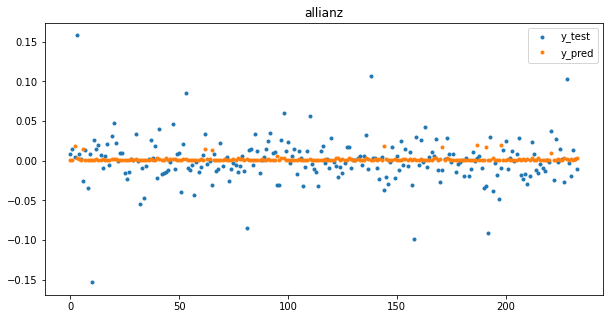

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


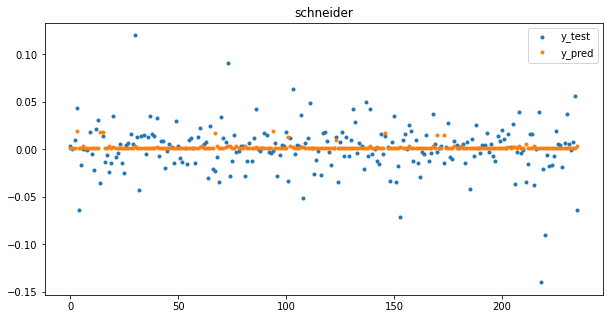

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


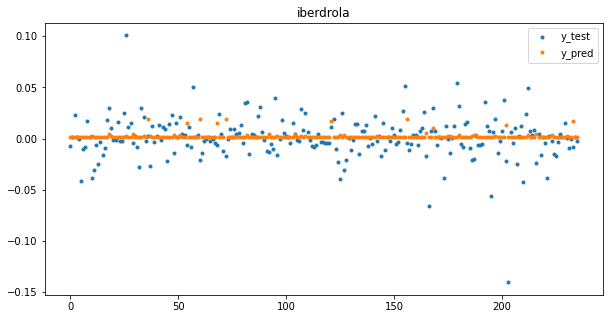

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


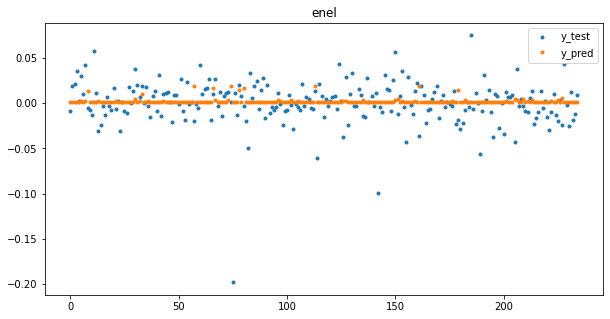

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


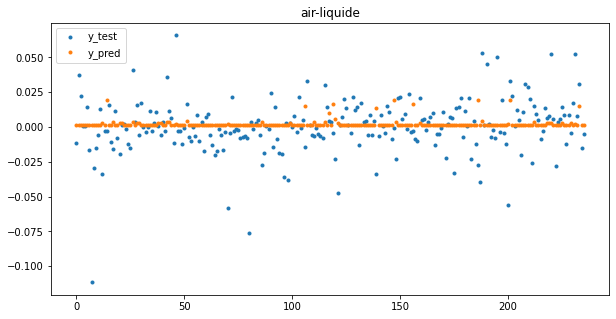

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


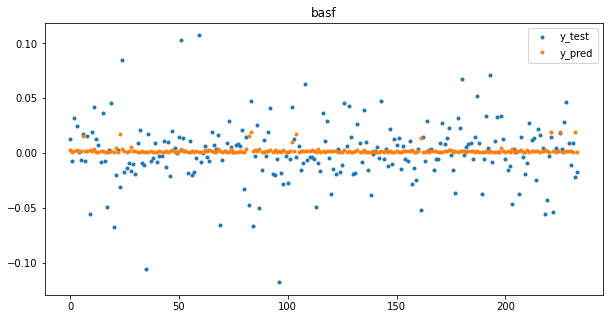

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


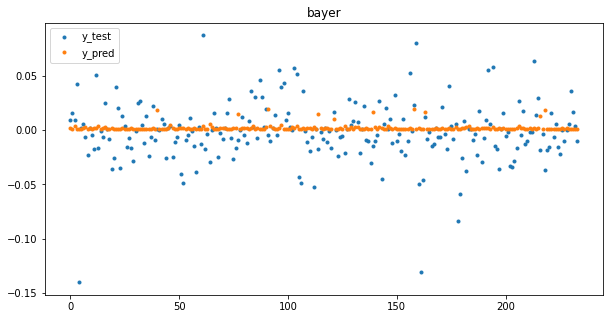

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


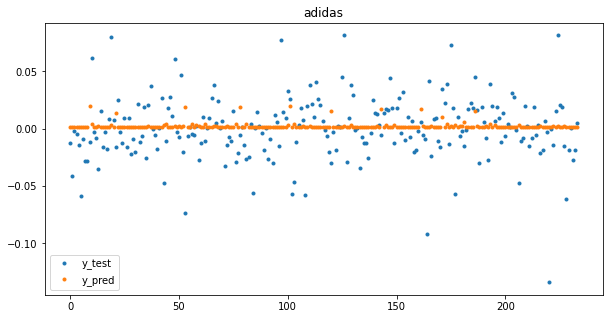

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


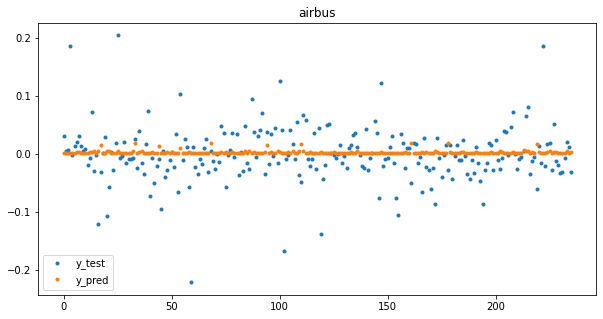

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


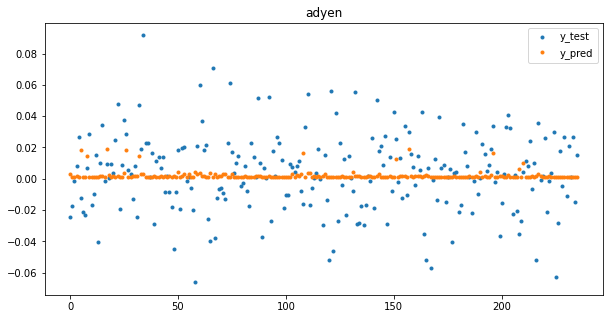

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


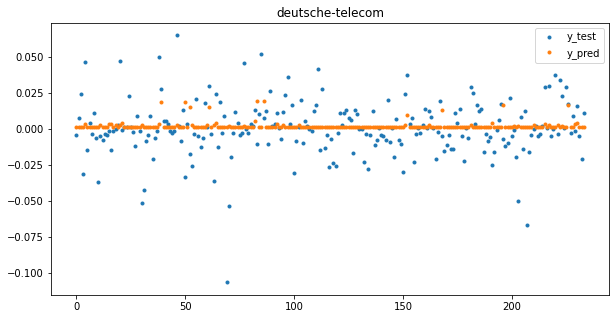

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


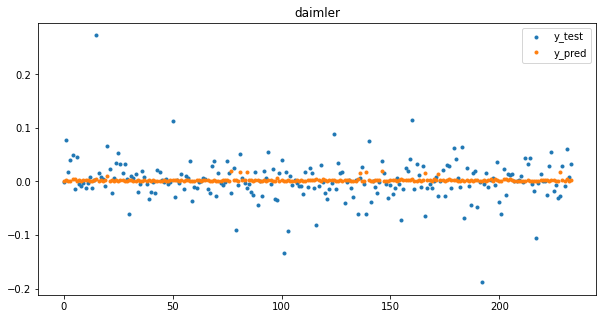

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


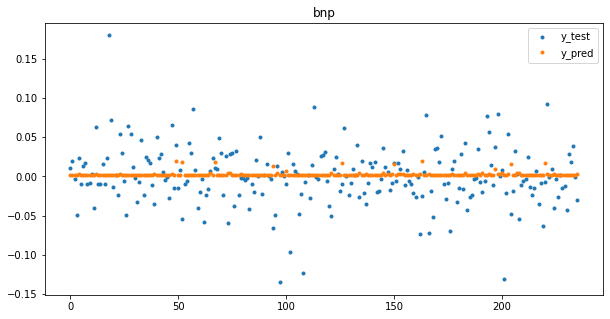

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


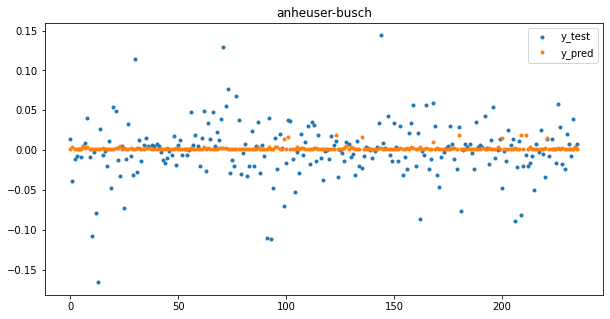

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


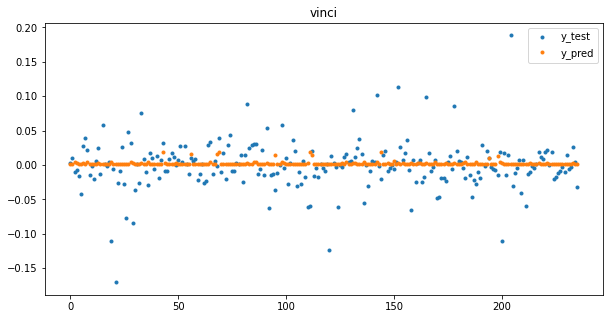

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


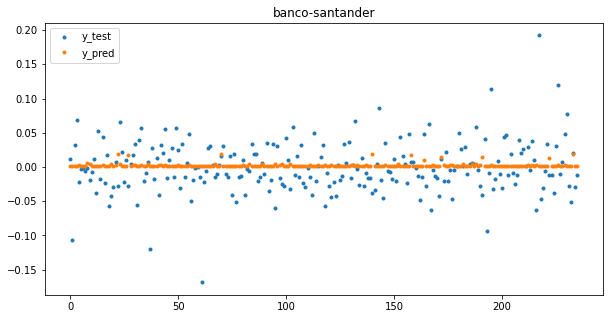

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


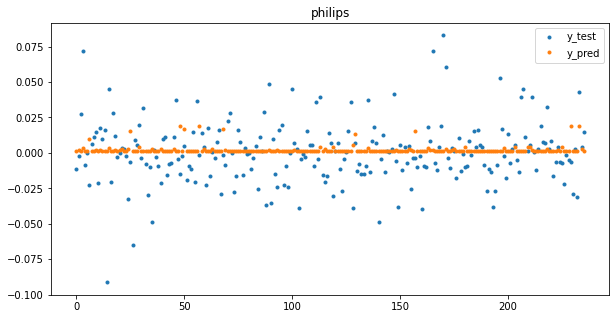

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


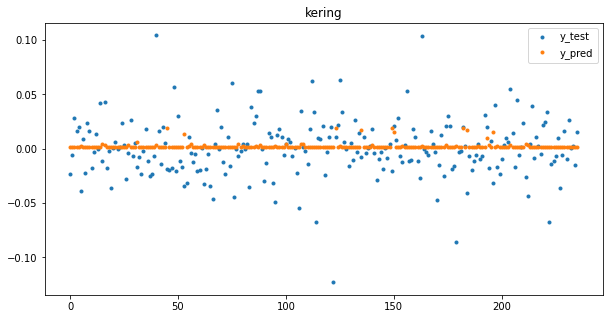

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


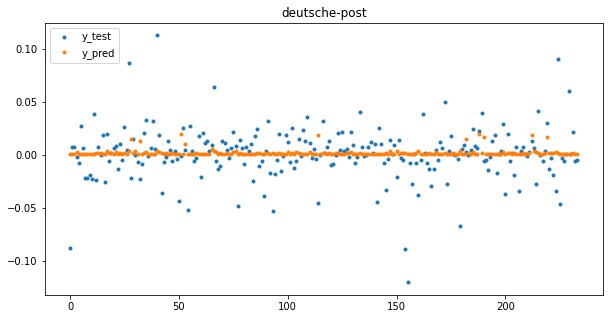

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


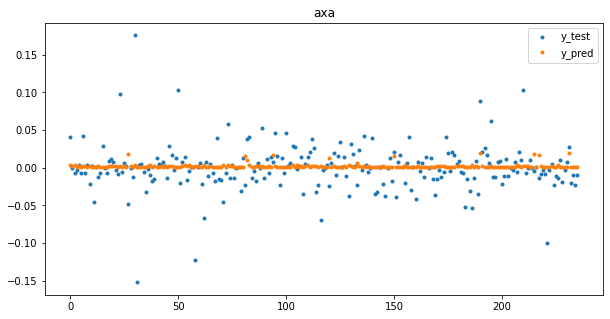

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


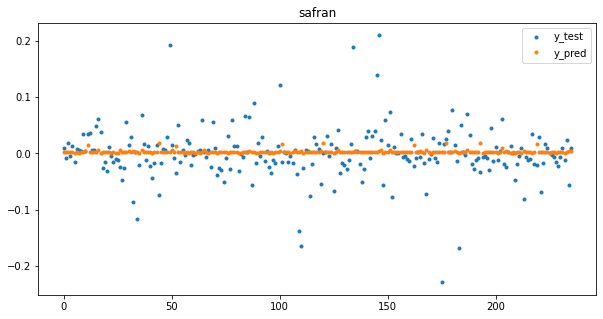

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


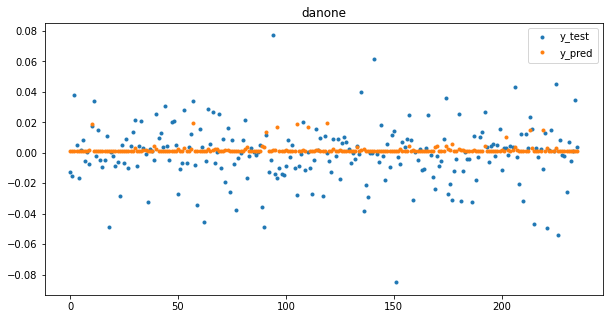

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


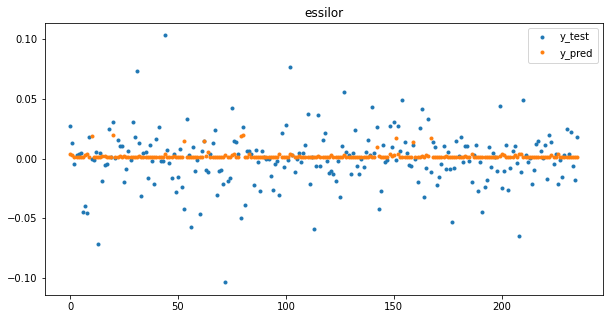

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


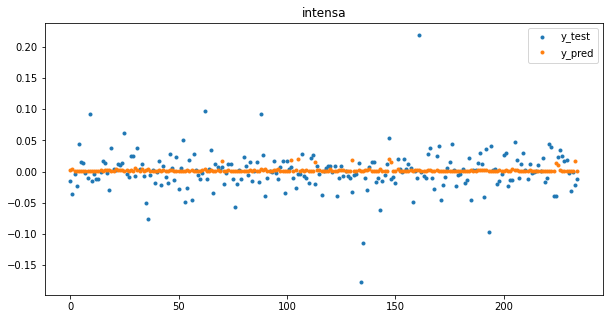

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


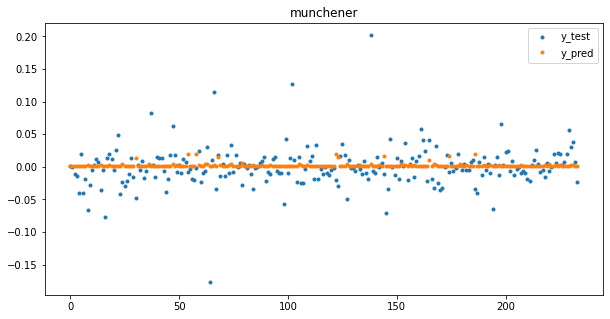

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


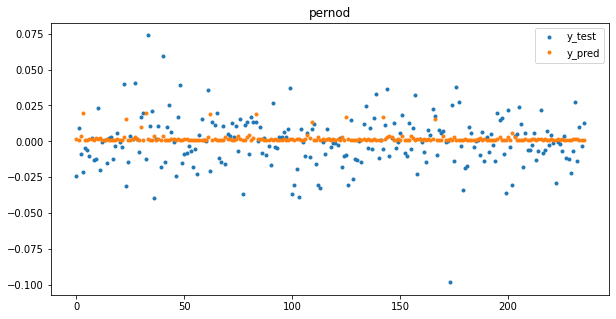

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


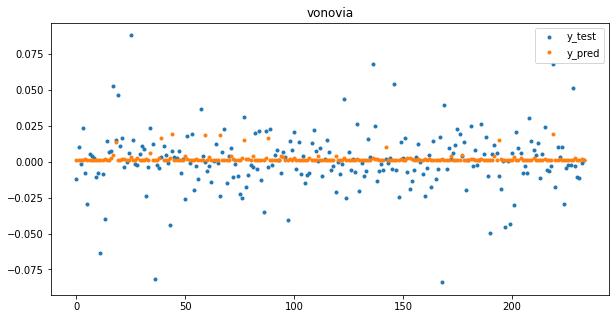

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


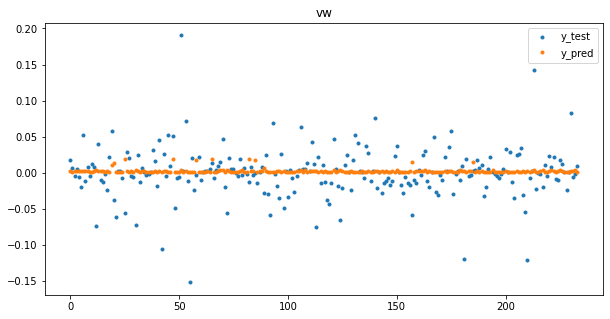

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


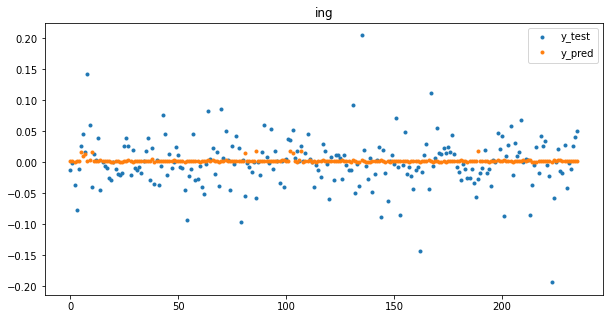

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


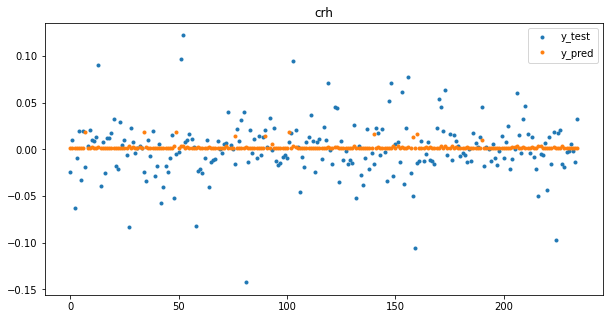

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


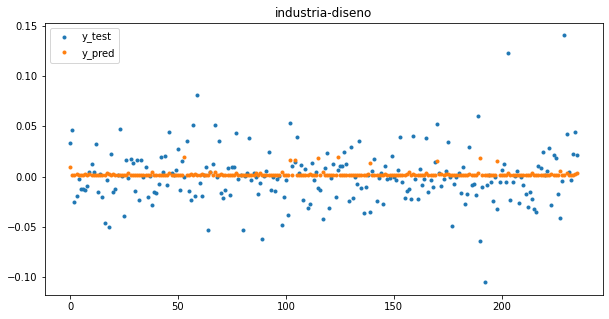

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 16)


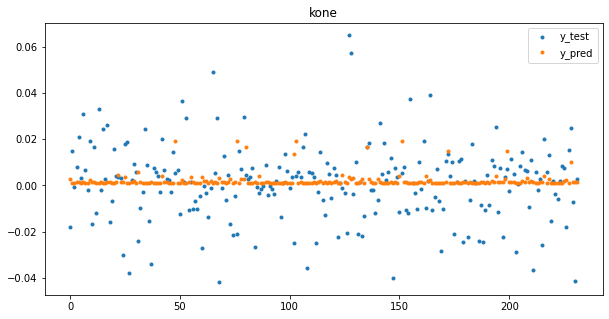

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


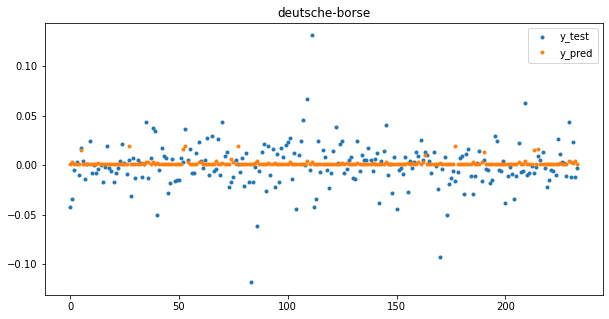

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


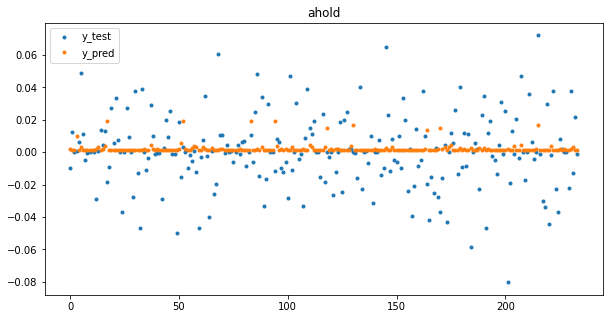

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


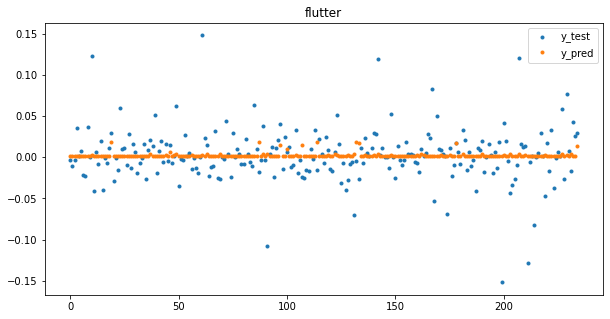

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


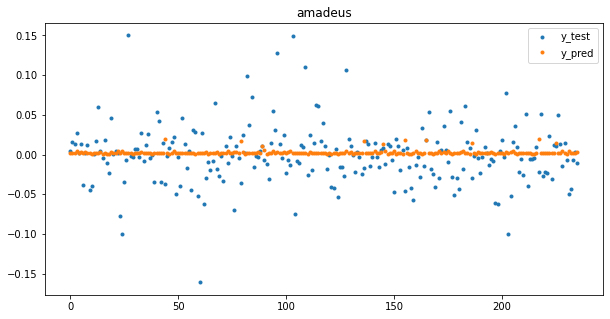

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


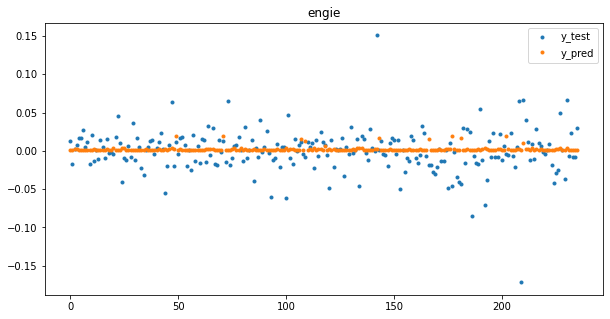

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


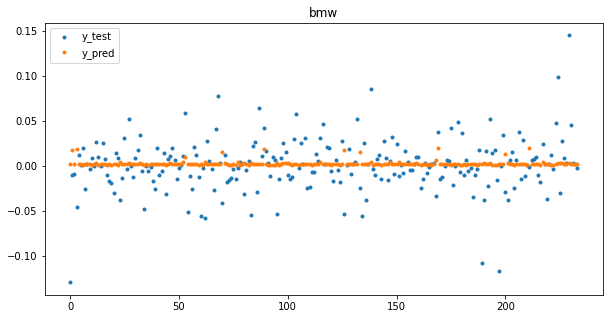

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


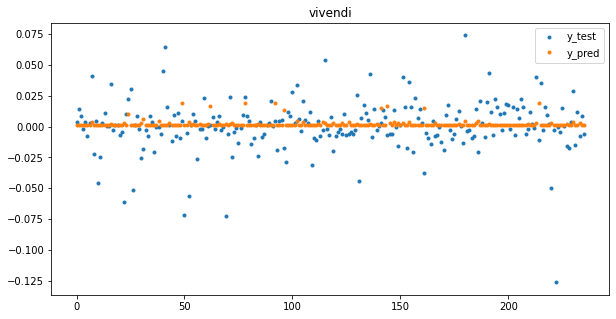

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


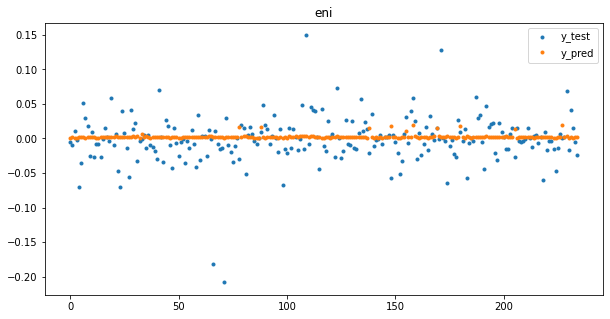

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 16)


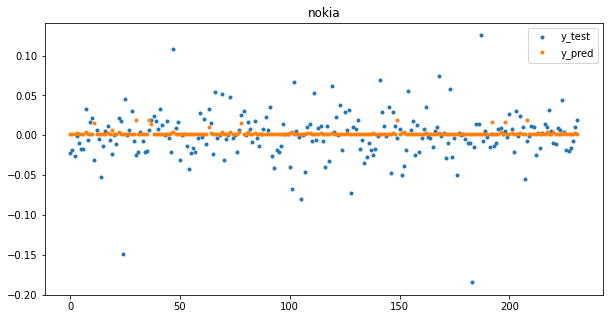

In [275]:
prediction = {}

 # data_data_to_predict_loc.shape[0]
for company in company_dict.keys():
    data_to_predict_loc, idx__loc = load_predict_data(company)
    X_test_loc, y_test_loc = shift_sequences(df = data_to_predict_loc, idx = idx__loc, length=20)
    print(X_test_loc.shape)
    
    prediction_loc = model.predict(X_test_loc)
    prediction[company] = prediction_loc.ravel()
    
    plt.figure(figsize=(10,5))
    plt.plot(y_test_loc, '.', label='y_test')
    plt.plot(prediction[company], '.', label = 'y_pred')
    plt.legend()
    plt.title(company)
    plt.show()

In [272]:
prediction['nokia'].shape

(232, 1)

In [278]:
prediction['asml']

array([0.00254707, 0.00118564, 0.01674582, 0.00177993, 0.00136265,
       0.0017426 , 0.00143812, 0.00177993, 0.00148748, 0.00161699,
       0.00135458, 0.00144053, 0.0013033 , 0.00118564, 0.00128448,
       0.00130719, 0.00585582, 0.00205268, 0.00142653, 0.00123342,
       0.00118564, 0.00118564, 0.00118564, 0.00139154, 0.00118564,
       0.00118564, 0.00128156, 0.00119726, 0.00118564, 0.00254802,
       0.00118564, 0.00160312, 0.00155784, 0.00131595, 0.00156587,
       0.00118564, 0.00118564, 0.00170965, 0.00436538, 0.00127529,
       0.00118564, 0.00177542, 0.01902643, 0.01674582, 0.00135007,
       0.00136443, 0.00139154, 0.00163714, 0.0013033 , 0.00130484,
       0.00120208, 0.00339442, 0.00143812, 0.00144444, 0.00124477,
       0.00137879, 0.00139073, 0.00127455, 0.00136434, 0.00213675,
       0.00226539, 0.00436538, 0.00128819, 0.00149589, 0.00122197,
       0.00396709, 0.00167352, 0.00163714, 0.00326007, 0.00136434,
       0.0017053 , 0.00118564, 0.00159881, 0.00118564, 0.00158

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


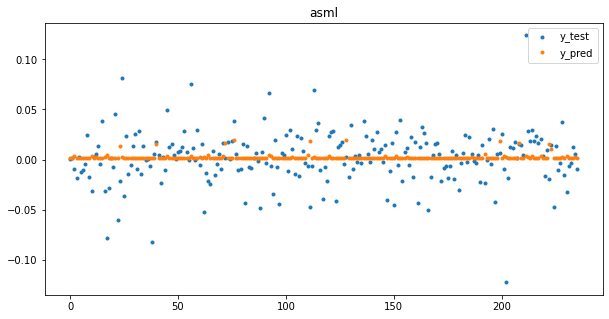

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


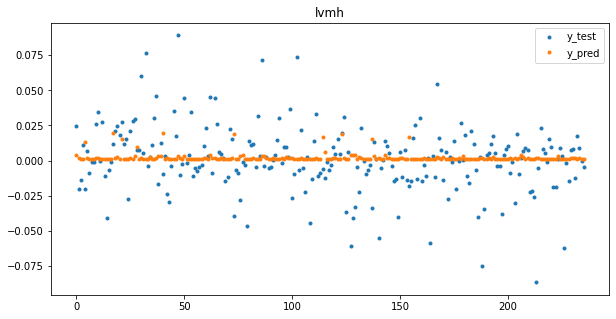

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


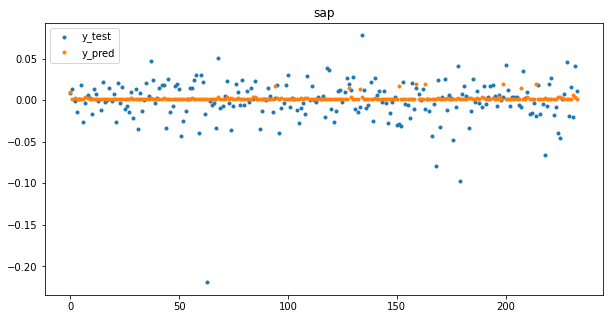

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(239, 20, 16)


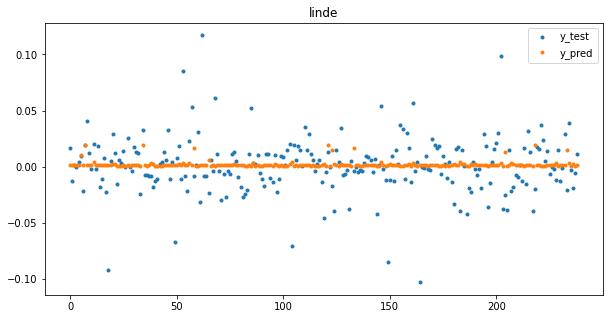

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


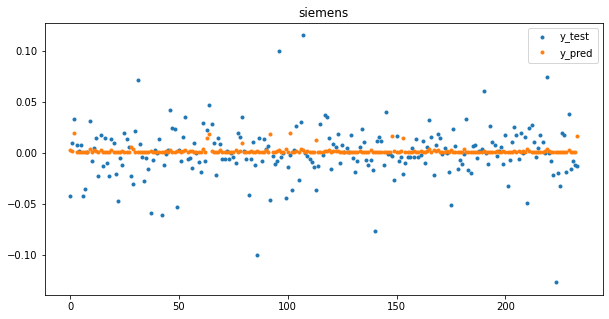

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


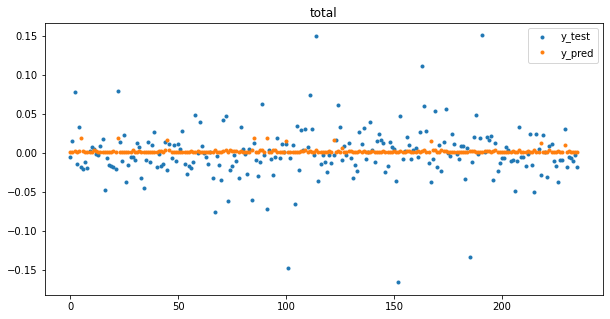

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


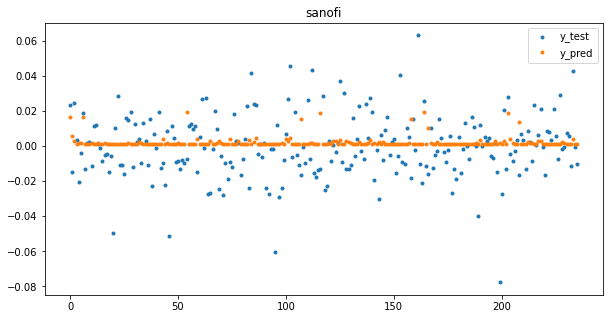

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


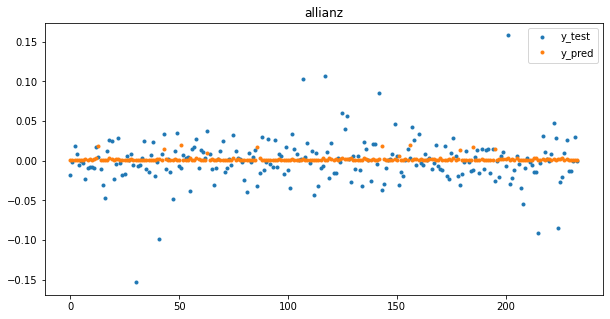

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


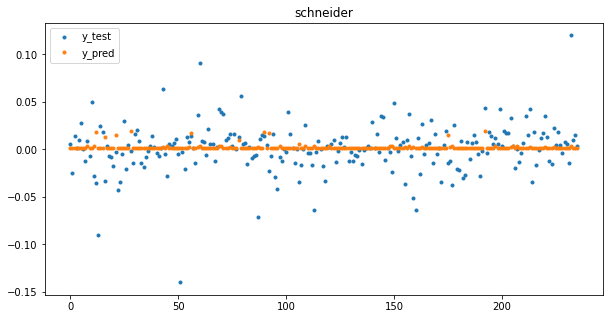

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


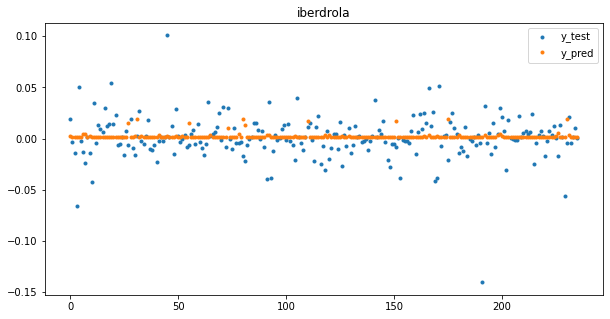

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


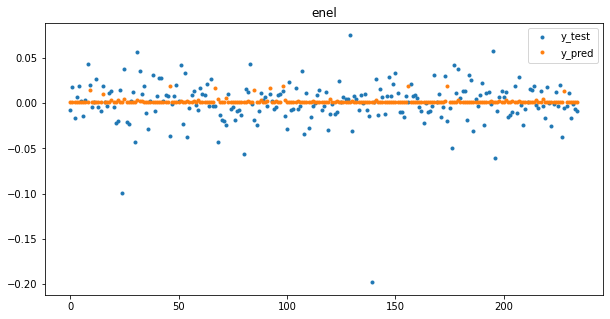

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


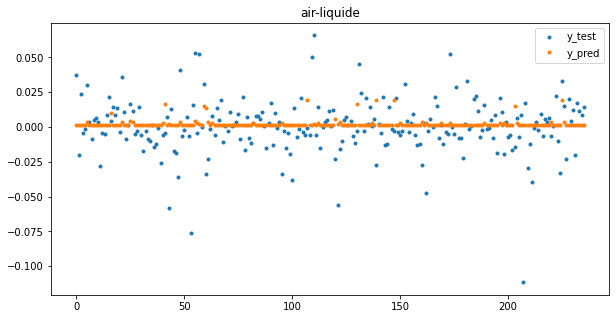

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


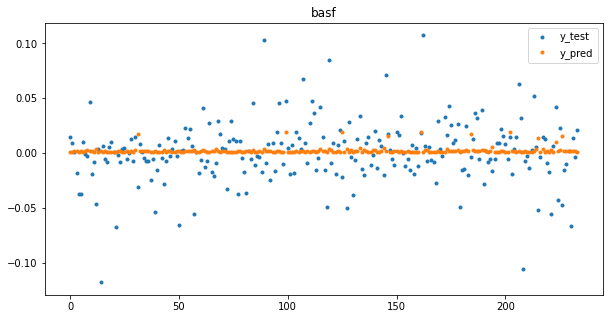

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


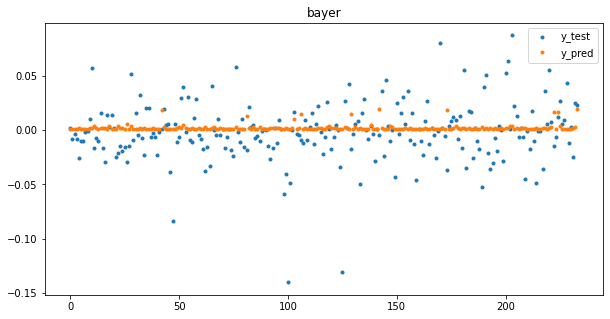

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


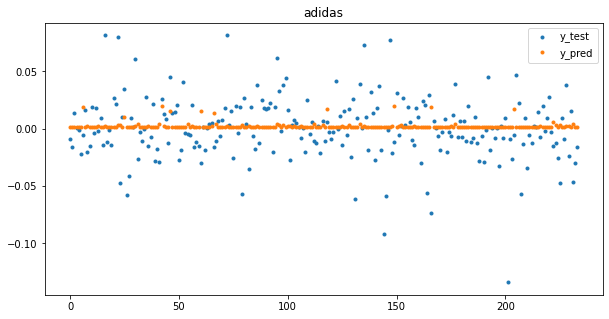

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


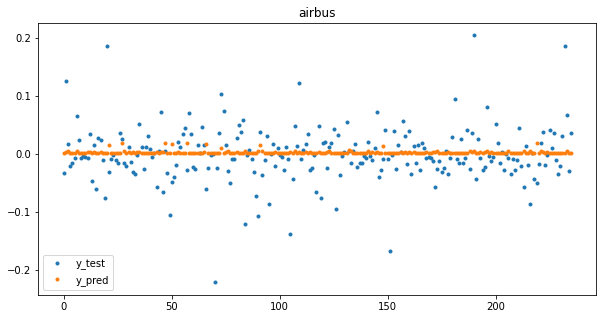

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


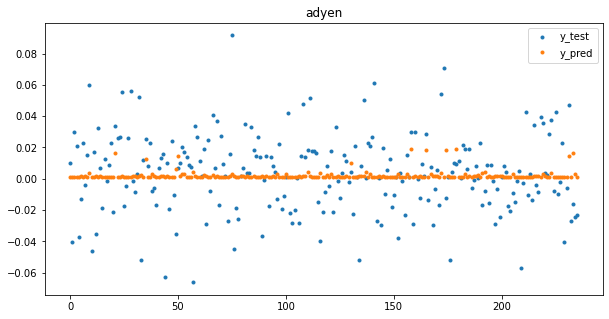

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


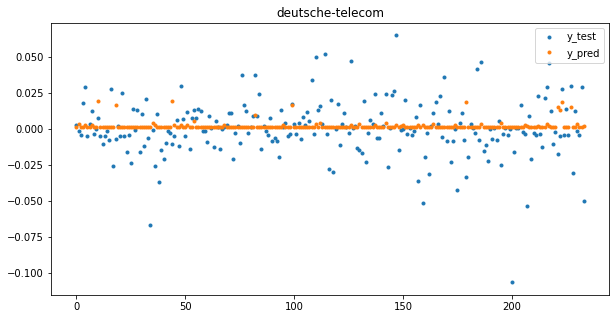

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


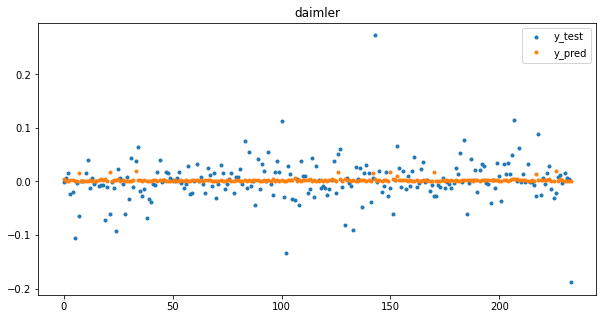

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


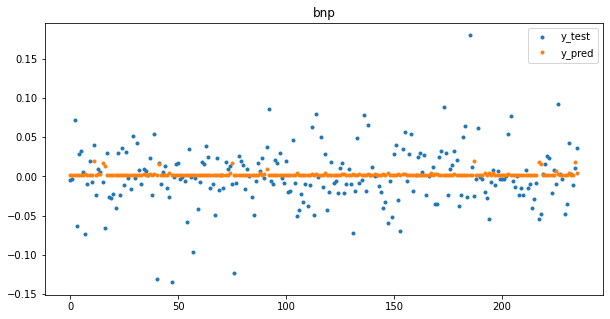

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


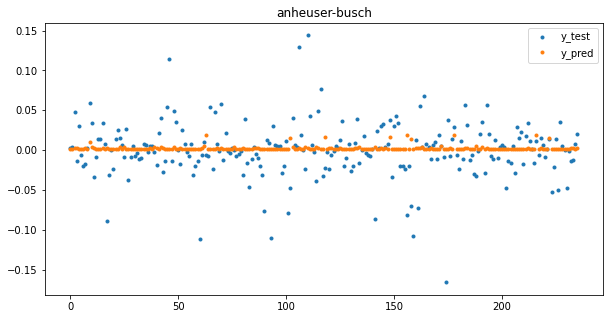

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


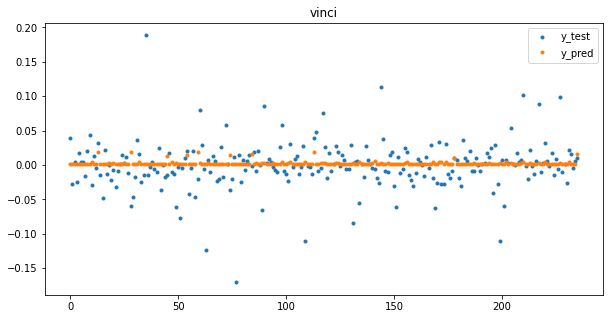

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


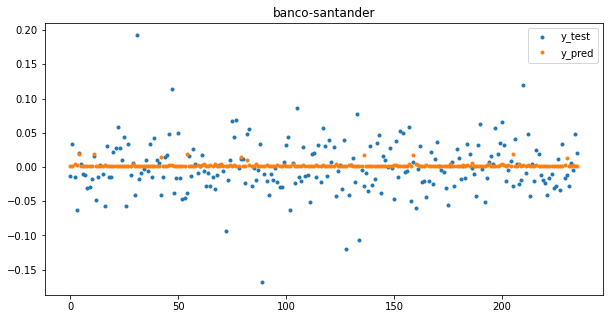

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


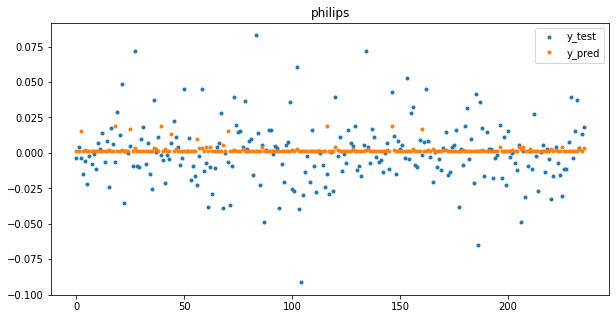

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


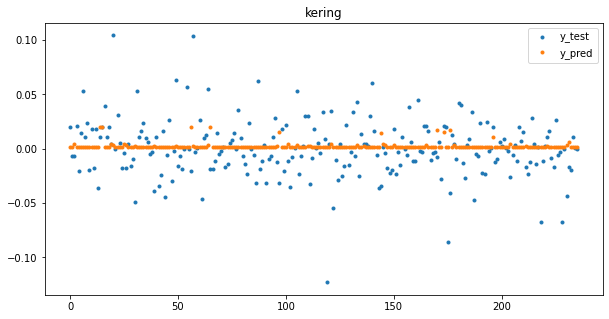

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


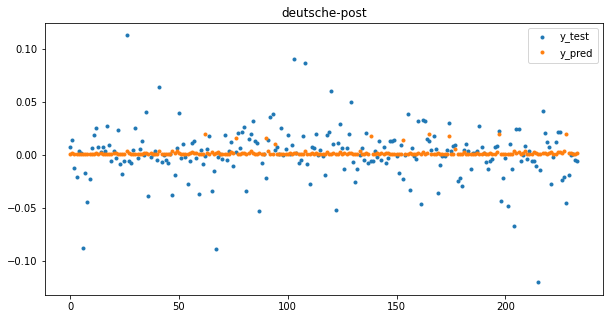

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


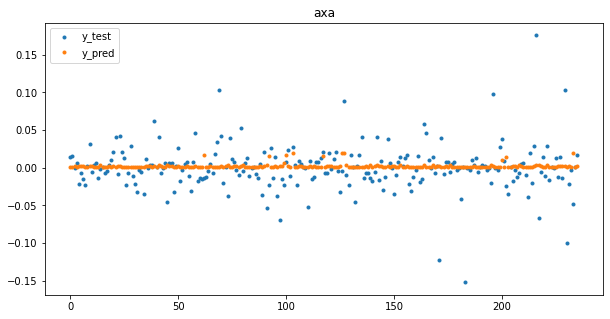

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


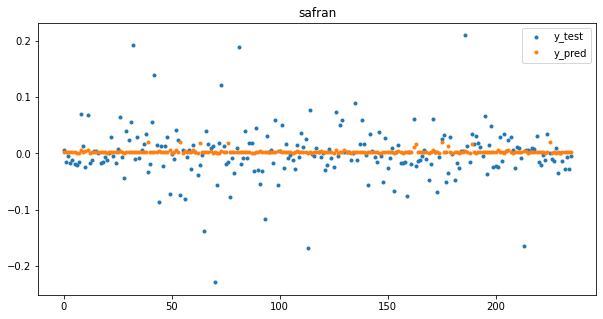

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


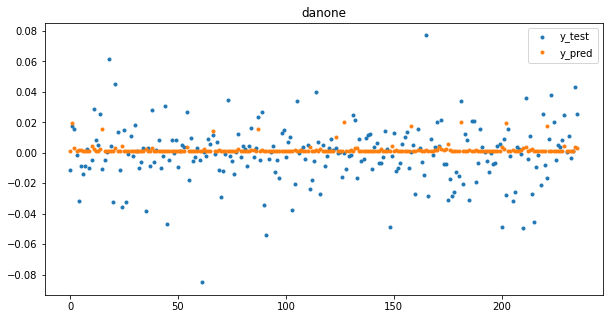

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


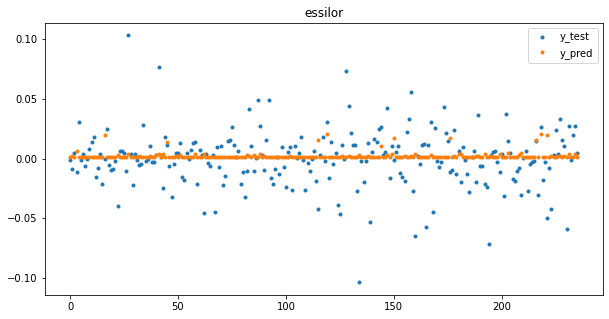

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


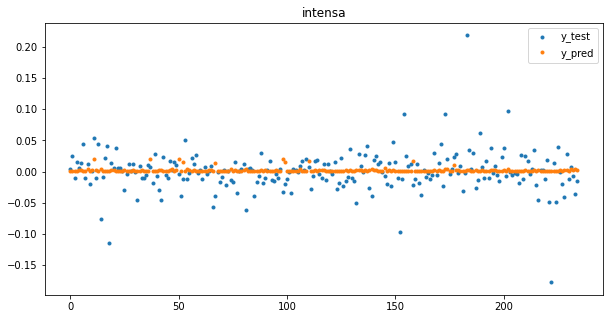

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


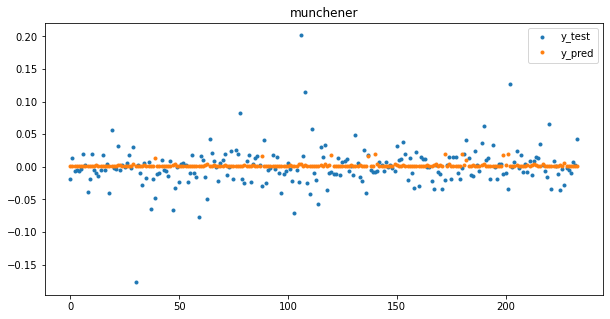

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


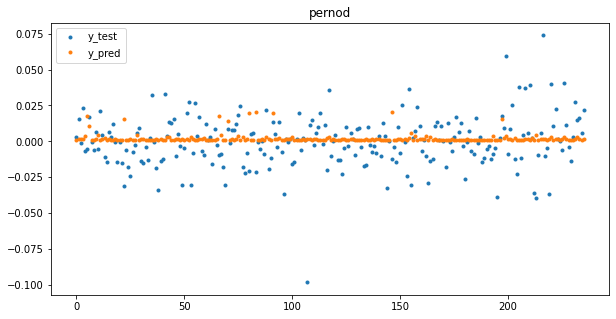

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


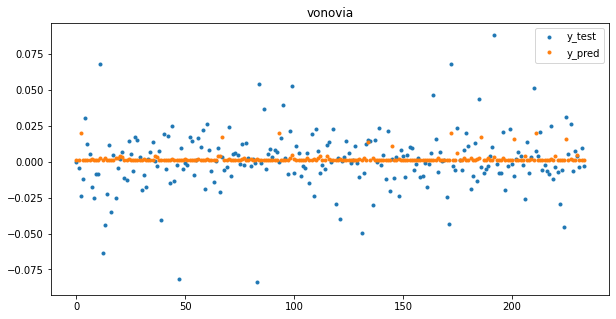

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


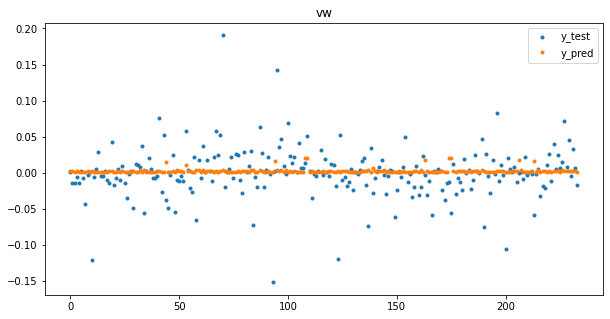

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


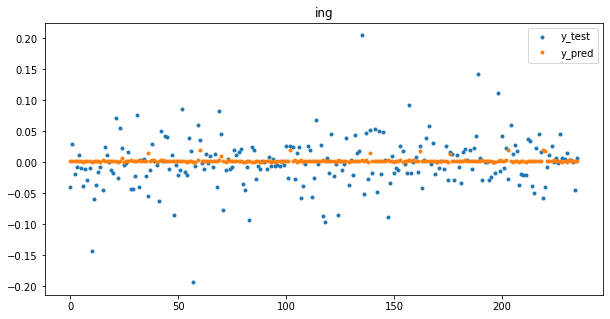

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


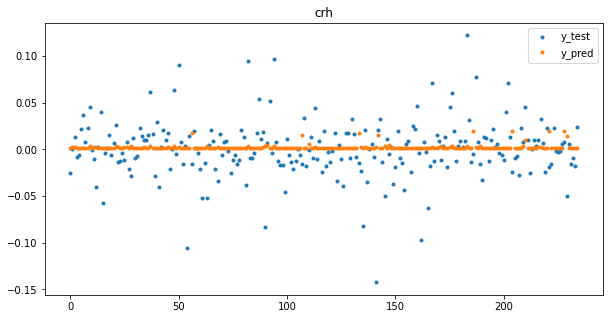

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


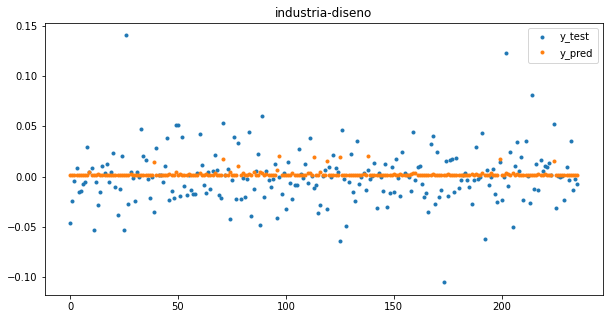

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 16)


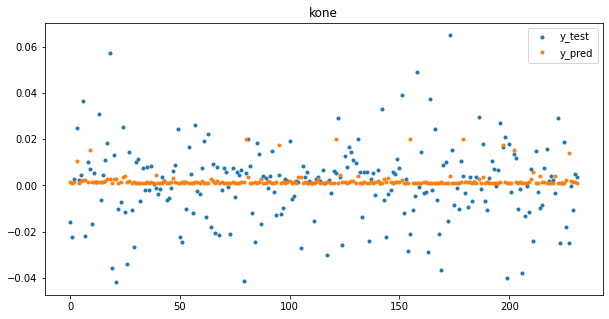

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


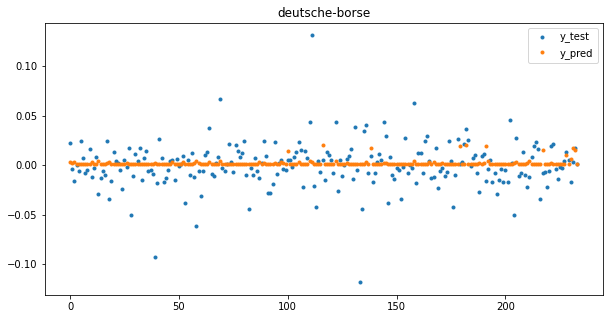

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


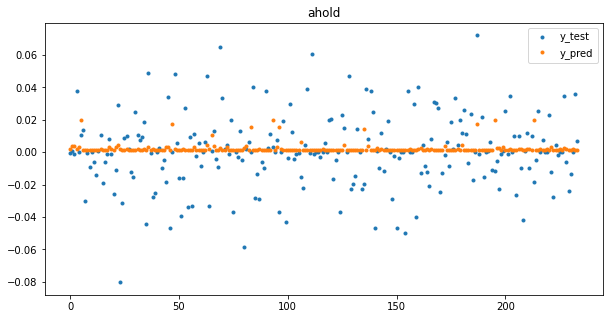

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


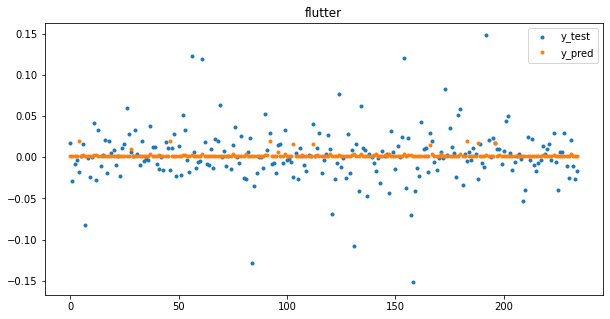

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


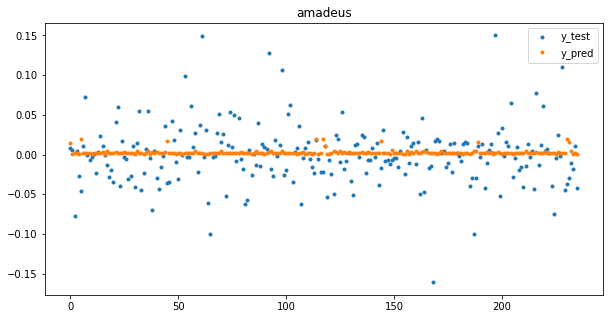

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


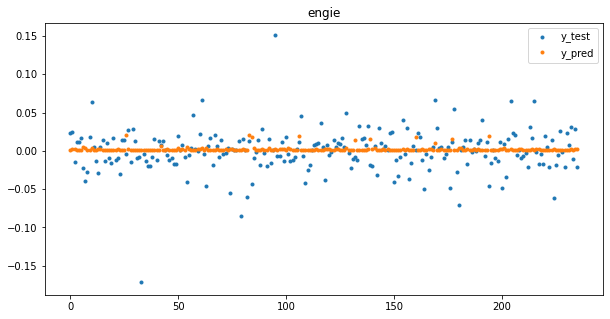

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 16)


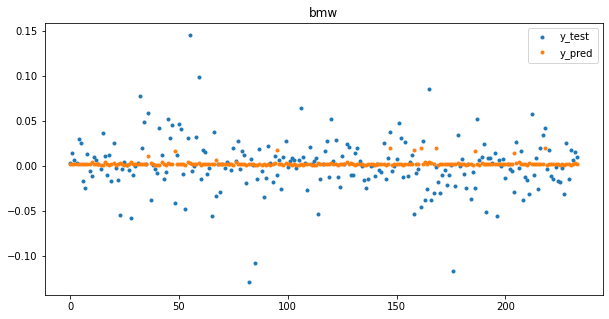

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 16)


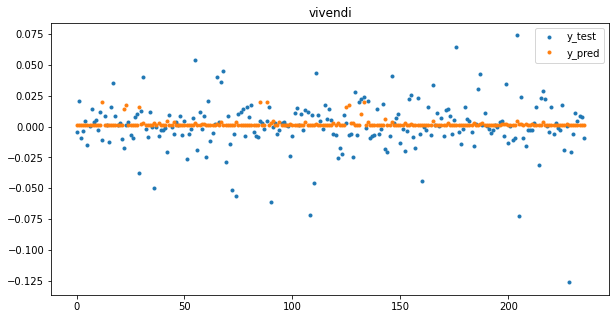

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 16)


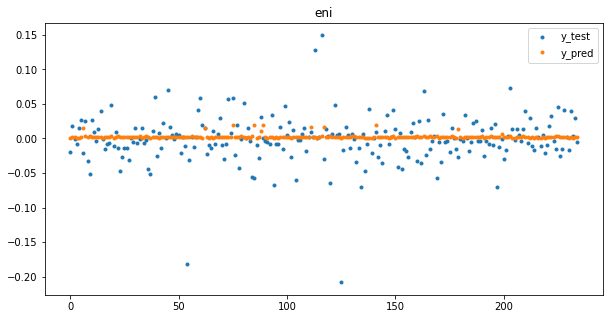

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 16)


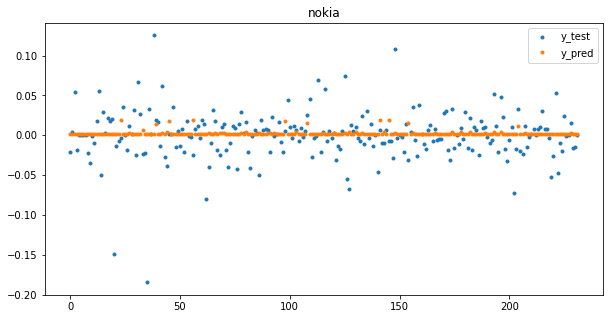

In [279]:
#---load the data with selected features

prediction = {}

 # data_data_to_predict_loc.shape[0]
for company in company_dict.keys():
    data_to_predict_loc, idx__loc = load_predict_data(company)
    X_test_loc, y_test_loc = shift_sequences(df = data_to_predict_loc, idx = idx__loc, length=20)
    print(X_test_loc.shape)
    
    prediction_loc = model.predict(X_test_loc)
    prediction[company] = prediction_loc.ravel()
    
    plt.figure(figsize=(10,5))
    plt.plot(y_test_loc, '.', label='y_test')
    plt.plot(prediction[company], '.', label = 'y_pred')
    plt.legend()
    plt.title(company)
    plt.show()

In [281]:
prediction

{'asml': array([0.00136434, 0.00156587, 0.00389098, 0.00128229, 0.00121451,
        0.00155738, 0.00177993, 0.00127529, 0.00177993, 0.00118564,
        0.00307328, 0.00118564, 0.00284411, 0.00118564, 0.00126986,
        0.00118564, 0.00213675, 0.00423647, 0.00144127, 0.00123342,
        0.00118564, 0.0013778 , 0.00127455, 0.01344039, 0.00233866,
        0.00147067, 0.00118564, 0.00118564, 0.00177542, 0.00147117,
        0.00144444, 0.00135007, 0.00149384, 0.00171841, 0.00129263,
        0.00125764, 0.00118564, 0.0017426 , 0.00151918, 0.00151728,
        0.01505088, 0.00144053, 0.00152809, 0.00148748, 0.00166666,
        0.00310705, 0.00149386, 0.00123595, 0.00147117, 0.00190331,
        0.00129413, 0.00118564, 0.00178818, 0.00119827, 0.00118564,
        0.00155784, 0.00389098, 0.00137257, 0.0013778 , 0.00140849,
        0.00254802, 0.00118564, 0.00292552, 0.00160312, 0.00423647,
        0.00162027, 0.0012275 , 0.00118564, 0.0013033 , 0.00122197,
        0.00118564, 0.00383773, 0.016745

In [282]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 20, 16)            33        
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 19, 128)           4224      
_________________________________________________________________
dropout_36 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 8, 64)             16448     
_________________________________________________________________
dropout_37 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 4, 64)            

In [284]:
model.save('saved_test')

INFO:tensorflow:Assets written to: saved_test/assets


# Train model on different period: Jan 2012 Juin 2016

**Check if Annual Volatility impacts model score**

In [17]:
def load_preproc_data(company='vinci'):
    """This function allows to load the data for chosen company,
    to select features make changes directly inside this function."""
    #---(1) Instantiate the Class 
    prep_class = Data_Prep(company, 252)



    #---(2) Load the first dataframe ready to use if no more modification
    df = prep_class.data_prep()



    #---(3) Function that allows us to delete some of the features we don't want to use for modelling 
    # Log Return is to False by default
    # *******************
    # if period < 252 , don't use Annual_vol
    #********************
    prep_class.select_features(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                            Volume_Change=False, Period_Volum=True, Annual_Vol=False,
                            Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    #---(4) Function that add the exogenous features that you need to select 
    # returns the dataframe ready to modelling 
    # and the list of the columns to rebase it later - no VIX because no rebase for VIX - kept unchanged 
    df = exo_selection(df, sp500=True, gold=True, eurusd=True, nasdaq=True, crude=True, vix=True)

    #---(5) Sort values to make sure they are ordered *in case and drop data column
    df = df.sort_values('Date')
#     df = df.drop(columns='Date')
    
    df = df.set_index('Date')
    
    #---Company code on stock market
    idx = df.columns[0][7:]
    
    return df, idx

In [18]:
#---load the data with selected features
data = []
idx = []
for company in company_dict.keys():
    data_loc, idx_loc = load_preproc_data(company)
    data.append(data_loc[:int(data_loc.shape[0]*0.6)])  # Pre-covid data
    idx.append(idx_loc)

(16399, 20, 15)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 20, 15)            31        
_________________________________________________________________
conv1d (Conv1D)              (None, 19, 128)           3968      
_________________________________________________________________
dropout (Dropout)            (None, 19, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 64)             16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 64)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 6

Epoch 49/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 50/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0104 - val_mean_absolute_error: 0.0104
Epoch 51/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 52/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 53/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 54/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 55/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103
Epoch 56/1000
513/513 - 4s - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0103 - val_mean_absolute_error: 0.0103


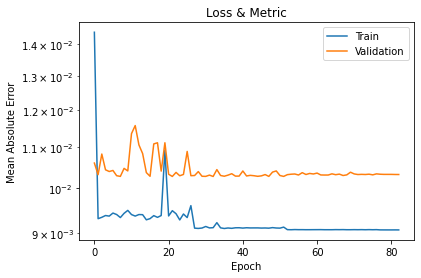

early stopping at 82 epoch.
val_mae: 0.01027256902307272


In [19]:
#---train the model
X_train, y_train, X_val, y_val, X_test, y_test, model = train_model(df=data,
                                                                    idx=idx,
                                                                    len_=20, 
                                                                    l_rate=0.01,
                                                                    batch_size=32,
                                                                    patience=50,
                                                                    loss='MAE',
                                                                    metric=MAE,
                                                                    plot_history=True, 
                                                                    verbose=2)

In [20]:
#baseline
np.mean(np.abs(y_test))

0.010177065090330745

In [22]:
#greater than the start date and smaller than the end date
def load_predict_data(company=None, start_date = '2020-01-03', end_date = '2020-12-31', len_=20):
    
    prep_class = Data_Prep_Api(company, 252)
    df = prep_class.data_prep_api() # (max=True)
    prep_class.select_features_api(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                        Volume_Change=False, Period_Volum=True, Annual_Vol=False,
                        Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    df = exo_selection_api(df, ["sp500","gold", "eurusd", "nasdaq", "crude", "vix"]) # ,max=True)

    df = df.sort_values('Date')
    
    start_date_delta = str((datetime.strptime('2020-01-03', '%Y-%m-%d') - timedelta(days=len_)).date())
    mask = (df['Date'] >= start_date_delta) & (df['Date'] < end_date)
    df = df.loc[mask]
    
    df = df.set_index('Date')
    
    #Company code on stock market
    idx = df.columns[0][7:]
    
    return df, idx

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


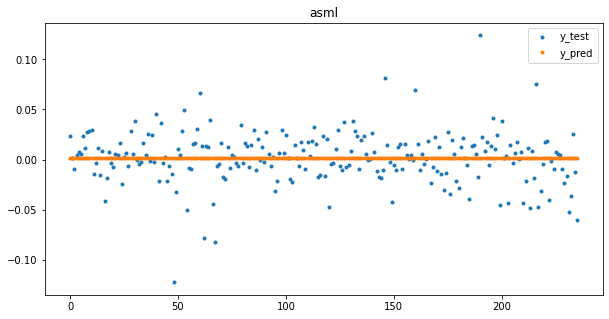

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


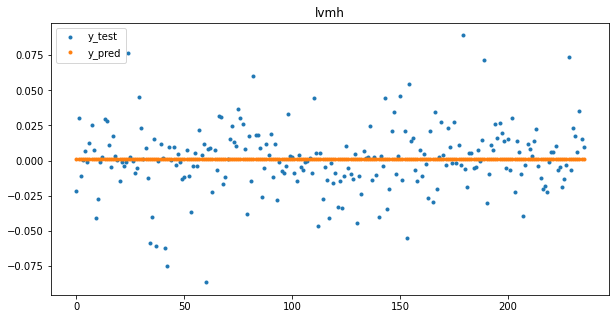

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


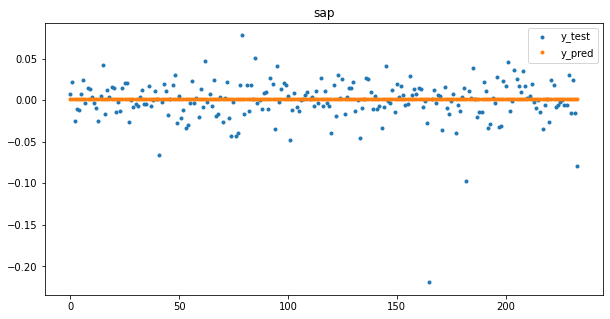

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(239, 20, 15)


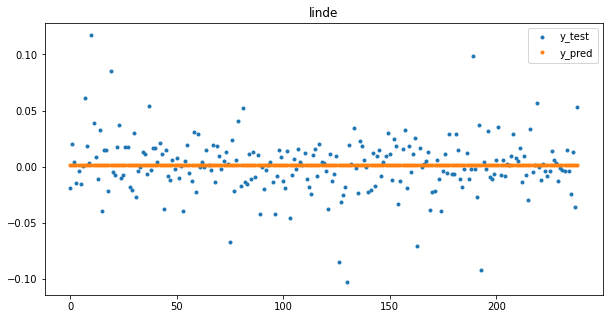

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


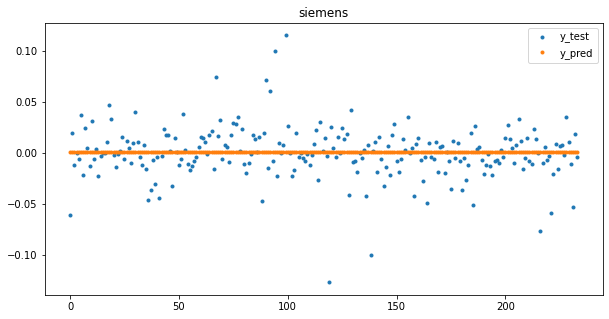

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


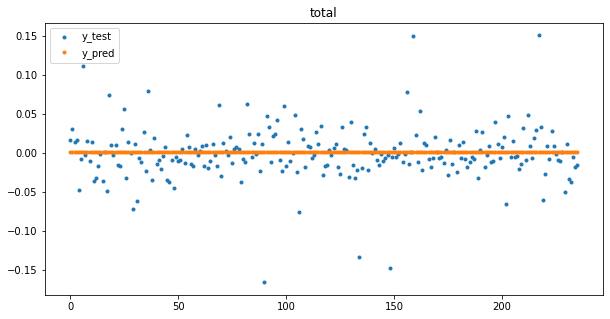

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


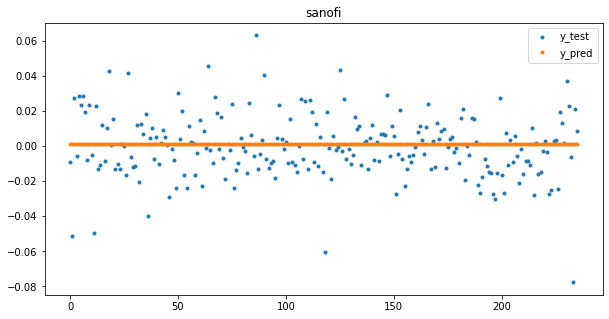

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


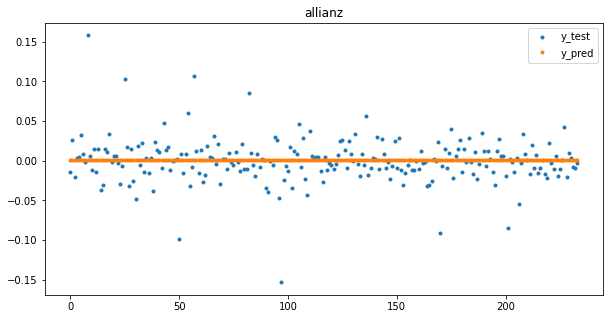

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


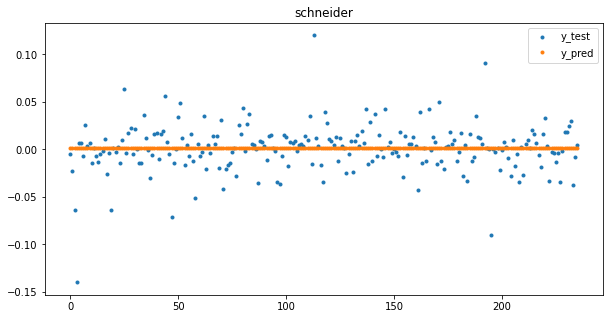

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


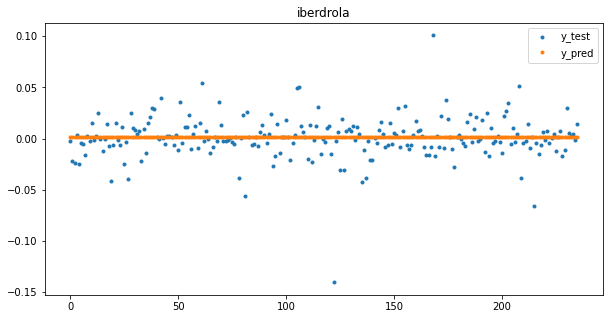

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


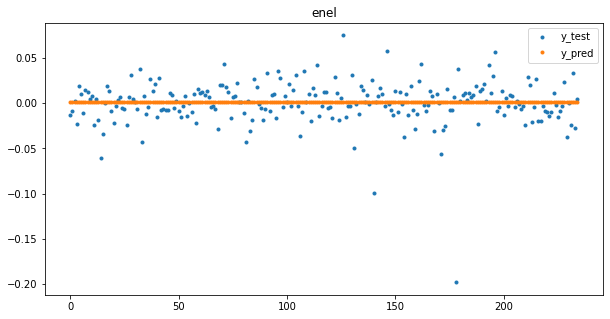

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


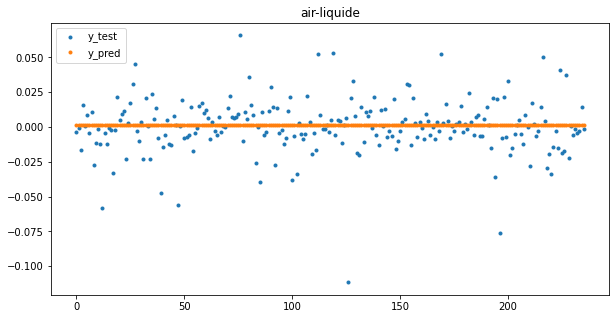

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


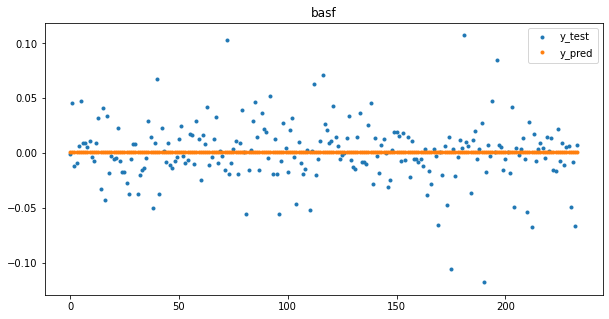

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


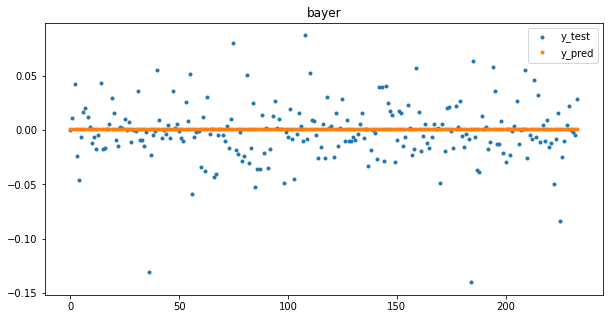

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


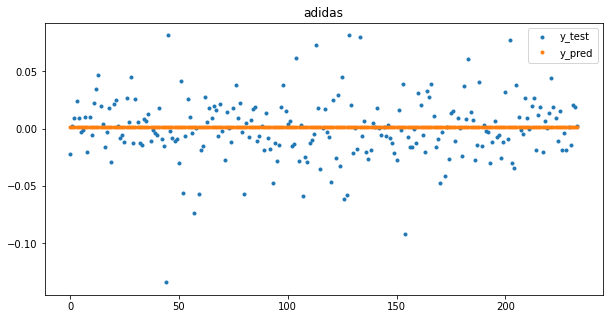

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


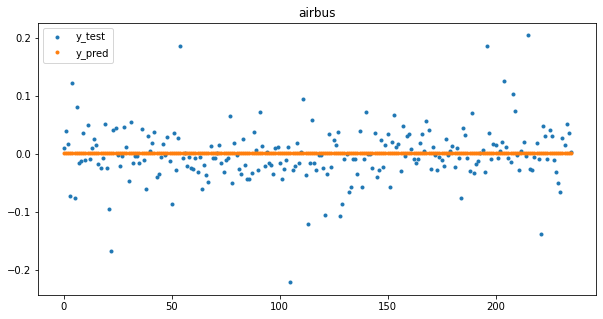

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


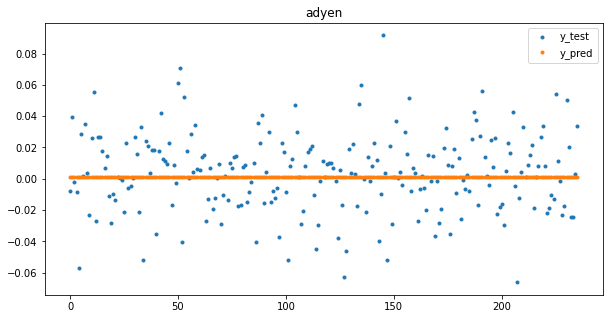

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


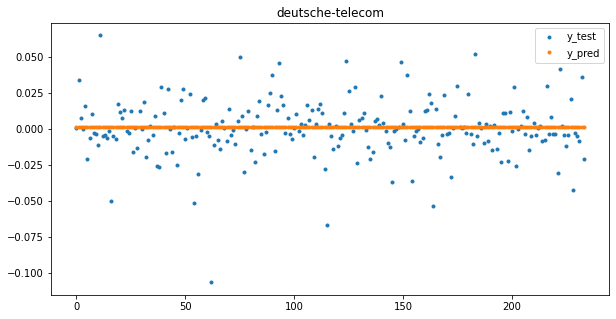

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


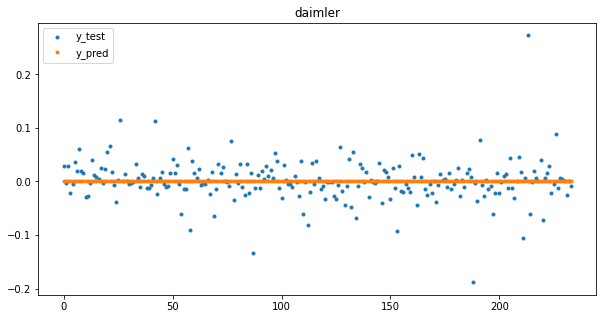

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


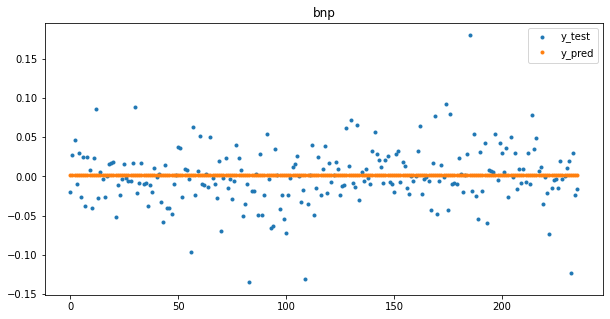

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


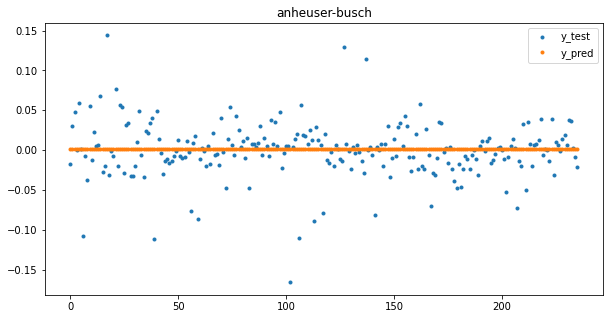

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


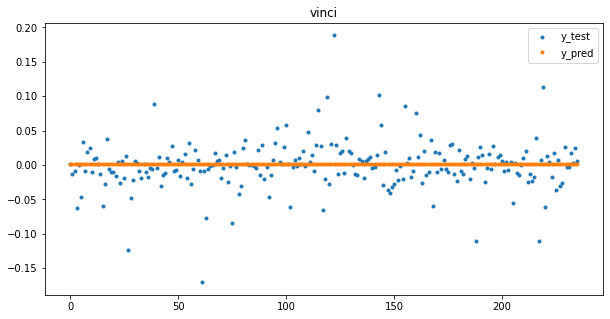

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


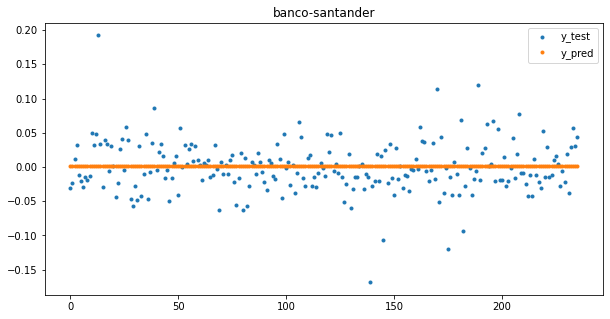

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


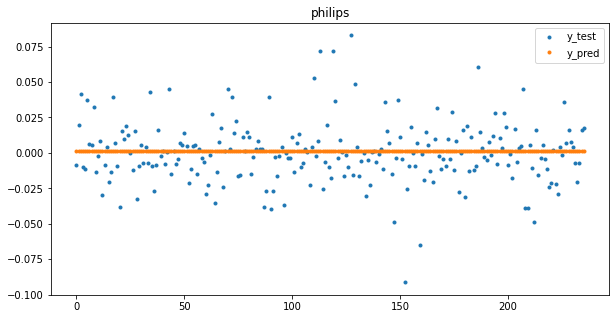

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


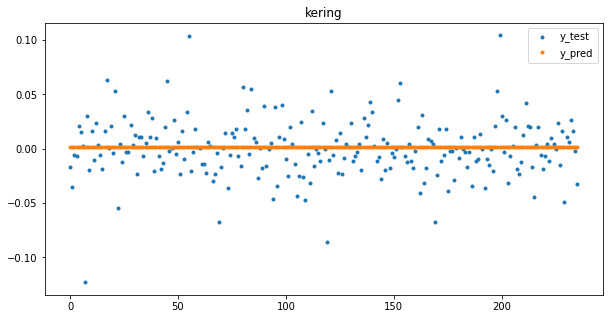

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


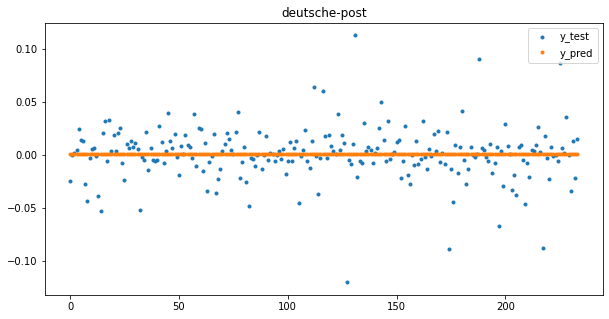

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


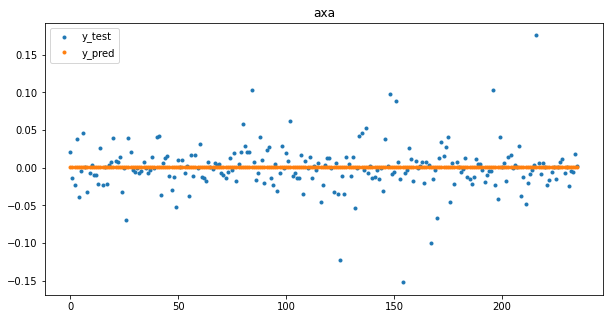

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


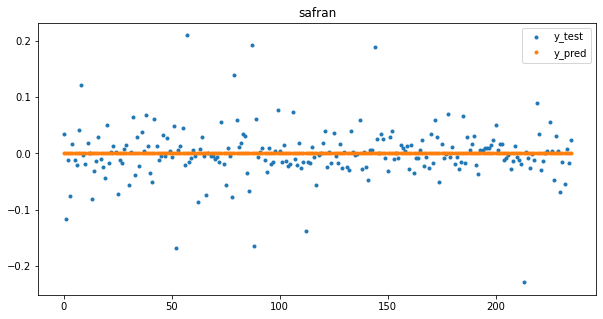

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


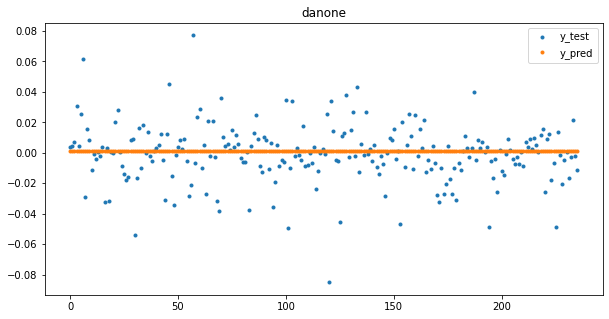

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


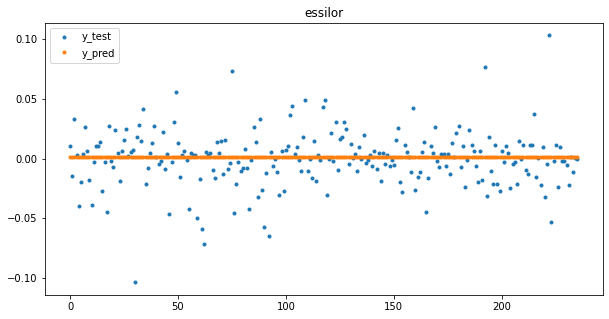

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


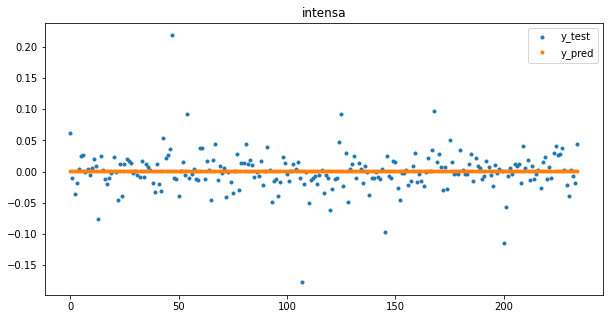

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


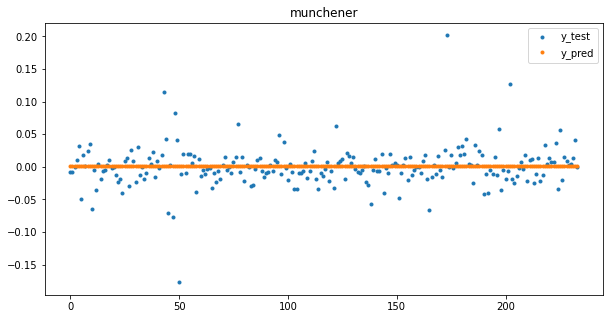

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


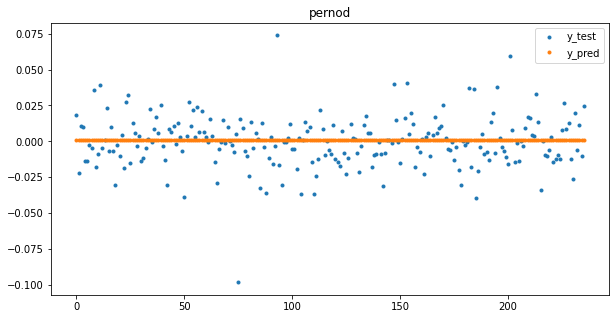

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


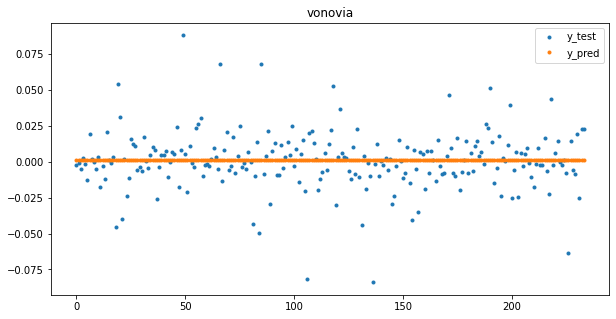

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


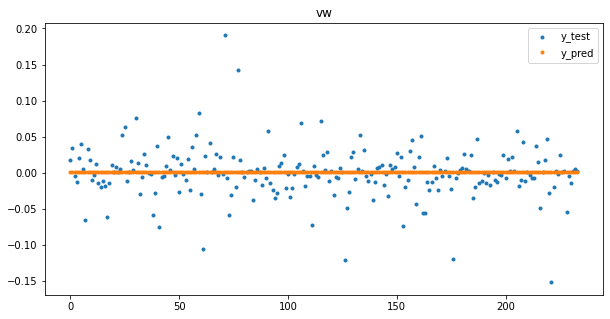

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


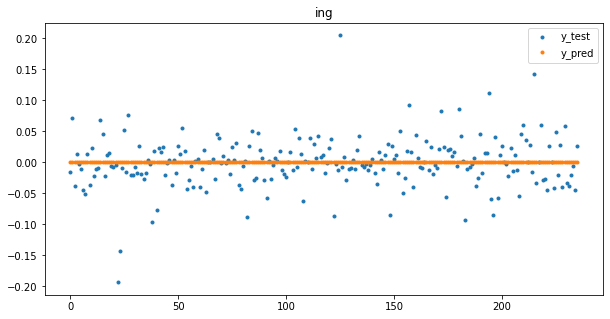

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


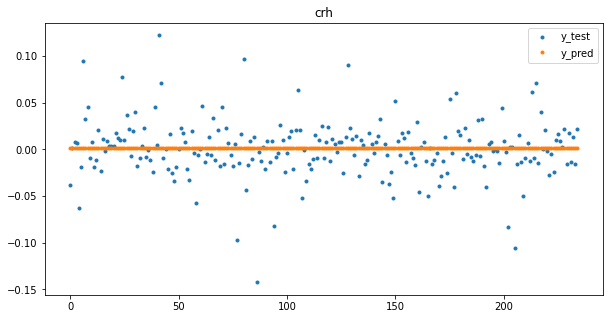

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


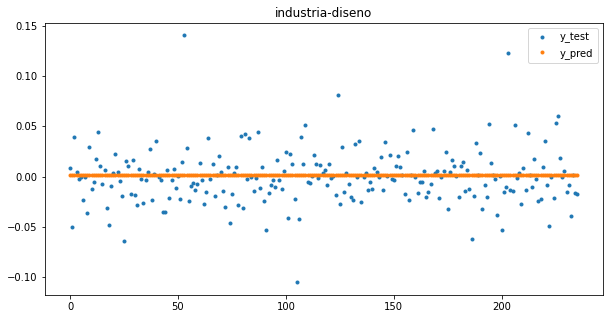

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 15)


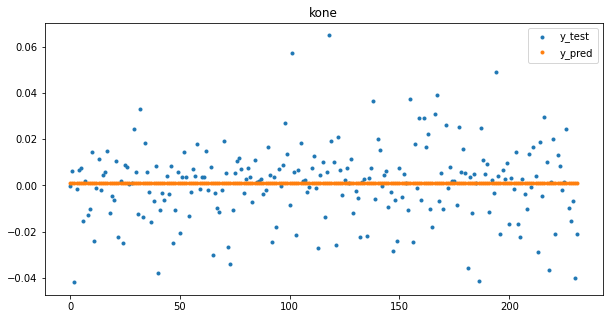

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


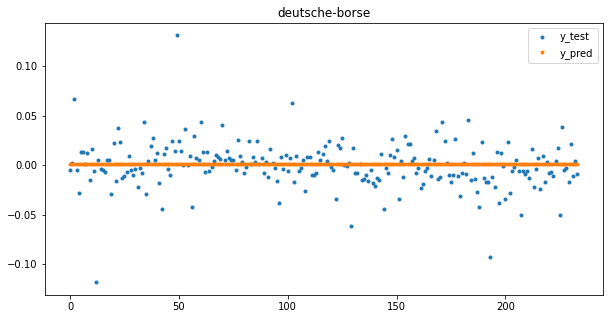

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


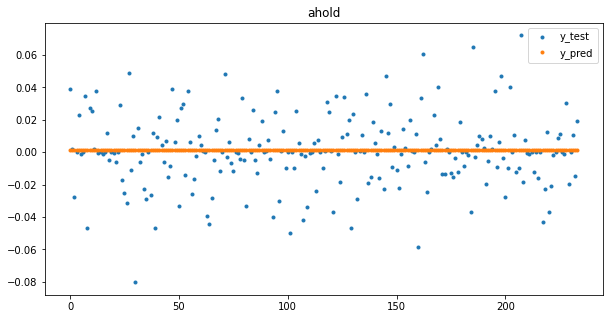

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


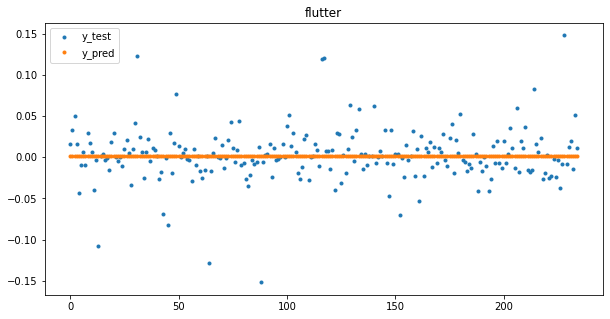

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


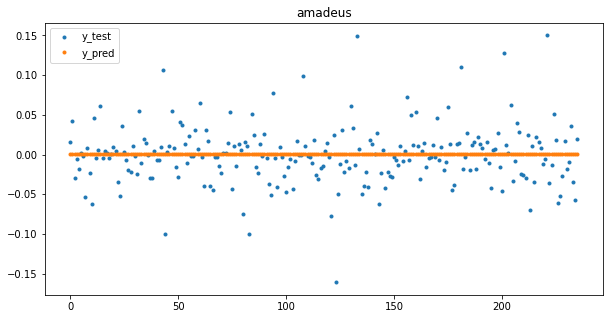

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


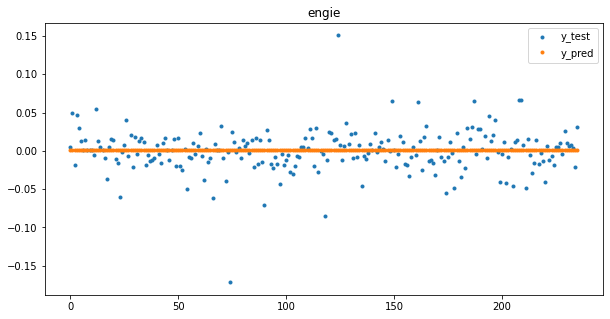

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(234, 20, 15)


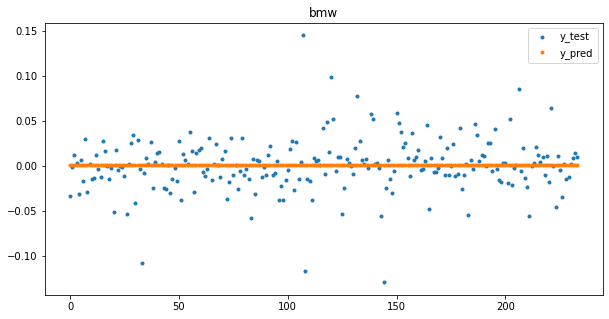

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(236, 20, 15)


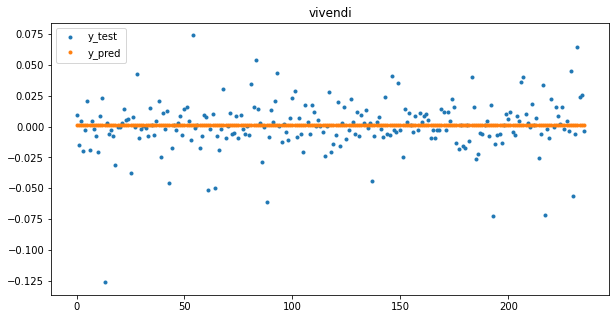

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(235, 20, 15)


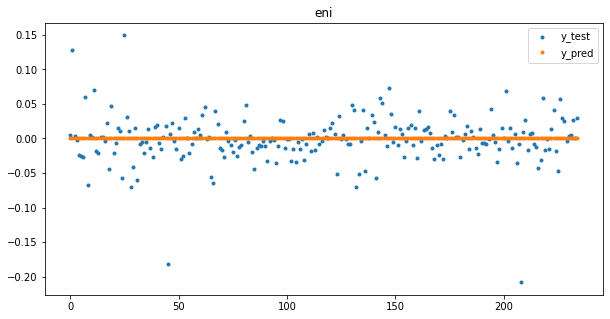

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(232, 20, 15)


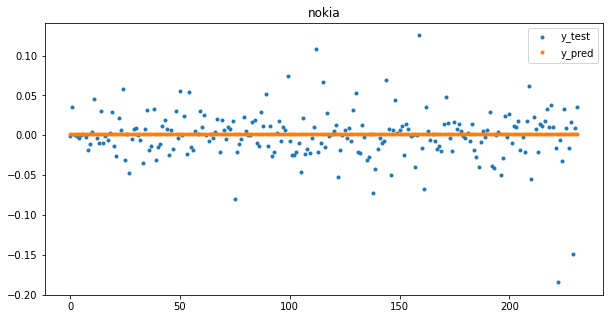

In [23]:
#---load the data with selected features

prediction = {}

 # data_data_to_predict_loc.shape[0]
for company in company_dict.keys():
    data_to_predict_loc, idx__loc = load_predict_data(company)
    X_test_loc, y_test_loc = shift_sequences(df = data_to_predict_loc, idx = idx__loc, length=20)
    print(X_test_loc.shape)
    
    prediction_loc = model.predict(X_test_loc)
    prediction[company] = prediction_loc.ravel()
    
    plt.figure(figsize=(10,5))
    plt.plot(y_test_loc, '.', label='y_test')
    plt.plot(prediction[company], '.', label = 'y_pred')
    plt.legend()
    plt.title(company)
    plt.show()

In [26]:
model.save('saved_5y_cnn')

INFO:tensorflow:Assets written to: saved_5y_cnn/assets


In [29]:
X_test_loc.shape

(232, 20, 15)